# 0.0. IMPORTAÇÕES

In [1]:
import pickle
import warnings

import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib              import pyplot  as plt
from sklearn                 import metrics as mt

from boruta                  import BorutaPy
from imblearn.over_sampling  import SMOTE
from scipy.stats             import chi2_contingency
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.preprocessing   import LabelEncoder, RobustScaler
from tabulate                import tabulate
from xgboost                 import XGBClassifier

warnings.filterwarnings('ignore')

## 0.1. Funções Auxiliares

In [2]:
# função de cramer V - utilizada na análise da correlação entre dados categóricos
def cramers_v(x, y):
    # Cria a tabela de contingência
    confusion_matrix = np.array(pd.crosstab(x, y))

    # Calcula a estatística qui-quadrado e o p-valor
    chi2, p, dof, ex = chi2_contingency(confusion_matrix)

    # Calcula a medida de Cramér V
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
           
    return v

## 0.2. Carregando os Dados

In [3]:
df_raw = pd.read_csv('csv/train.csv', low_memory=False)

In [4]:
df_test = pd.read_csv('csv/test.csv', low_memory=False)

# 1.0. DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Verificando as Colunas

In [6]:
cols_old = ['id', 'Classificacao do hotel', 'Meses da reserva ate o check-in',
            'Numero de pernoites reservadas', 'Numero de hospedes',
            'Regime de alimentacao', 'Nacionalidade', 'Forma de Reserva',
            'Ja se hospedou anteriormente', 'Tipo do quarto reservado',
            'Reserva feita por agencia de turismo', 'Reserva feita por empresa',
            'Reserva com Estacionamento', 'Reserva com Observacoes',
            'Reserva Cancelada']

snakecase = lambda x: x.replace(' ', '_').lower()

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new
df_test.columns = cols_new[0:-1]

## 1.2. Dimensionando os dados

In [7]:
print('Quantidade de linhas: {}'.format(df1.shape[0]))
print('Quantidade de colunas: {}'.format(df1.shape[1]))

Quantidade de linhas: 72159
Quantidade de colunas: 15


## 1.3. Verificando o tipo dos dados

In [8]:
df1.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check-in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                      float64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anteriormente             object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
dtype: object

## 1.4. Contabilizando os NA

In [9]:
df1.isna().sum()

id                                         0
classificacao_do_hotel                     0
meses_da_reserva_ate_o_check-in            0
numero_de_pernoites_reservadas             0
numero_de_hospedes                         3
regime_de_alimentacao                      0
nacionalidade                           1093
forma_de_reserva                           0
ja_se_hospedou_anteriormente               0
tipo_do_quarto_reservado                   0
reserva_feita_por_agencia_de_turismo       0
reserva_feita_por_empresa                  0
reserva_com_estacionamento                 0
reserva_com_observacoes                    0
reserva_cancelada                          0
dtype: int64

## 1.5. Preenchendo os NA

In [10]:
# numero_de_hospedes - substituiremos pela moda
moda = df1['numero_de_hospedes'].mode()[0]
df1.loc[df1['numero_de_hospedes'].isna(), 'numero_de_hospedes'] = moda
df_test.loc[df_test['numero_de_hospedes'].isna(), 'numero_de_hospedes'] = moda
pickle.dump(moda, open('parameter/moda.pkl', 'wb'))
# nacionalidade
df1 = df1.dropna()

## 1.6. Alterando os tipos dos dados

In [11]:
df1.loc[:, 'numero_de_hospedes'] = df1['numero_de_hospedes'].astype('int64')

## 1.7. Estatística Descritiva

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1. Atributos numéricos

In [13]:
# tendência central
mean   = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersão
min_     = pd.DataFrame(num_attributes.apply(min)).T
max_     = pd.DataFrame(num_attributes.apply(max)).T
range_   = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
std      = pd.DataFrame(num_attributes.apply(np.std)).T
skew     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,120265.0,120264.0,60330.611235,60492.0,34667.061820,-0.012361,-1.195776
1,meses_da_reserva_ate_o_check-in,1.0,311.0,310.0,7.149481,3.0,25.858864,8.667134,79.717962
2,numero_de_pernoites_reservadas,0.0,1172.0,1172.0,15.847564,3.0,98.350017,8.758385,80.091005
3,numero_de_hospedes,0.0,1153.0,1153.0,14.253652,2.0,96.416677,8.728327,79.765502
4,reserva_cancelada,0.0,1.0,1.0,0.373287,0.0,0.483677,0.523969,-1.725505


### 1.7.2. Atributos categóricos

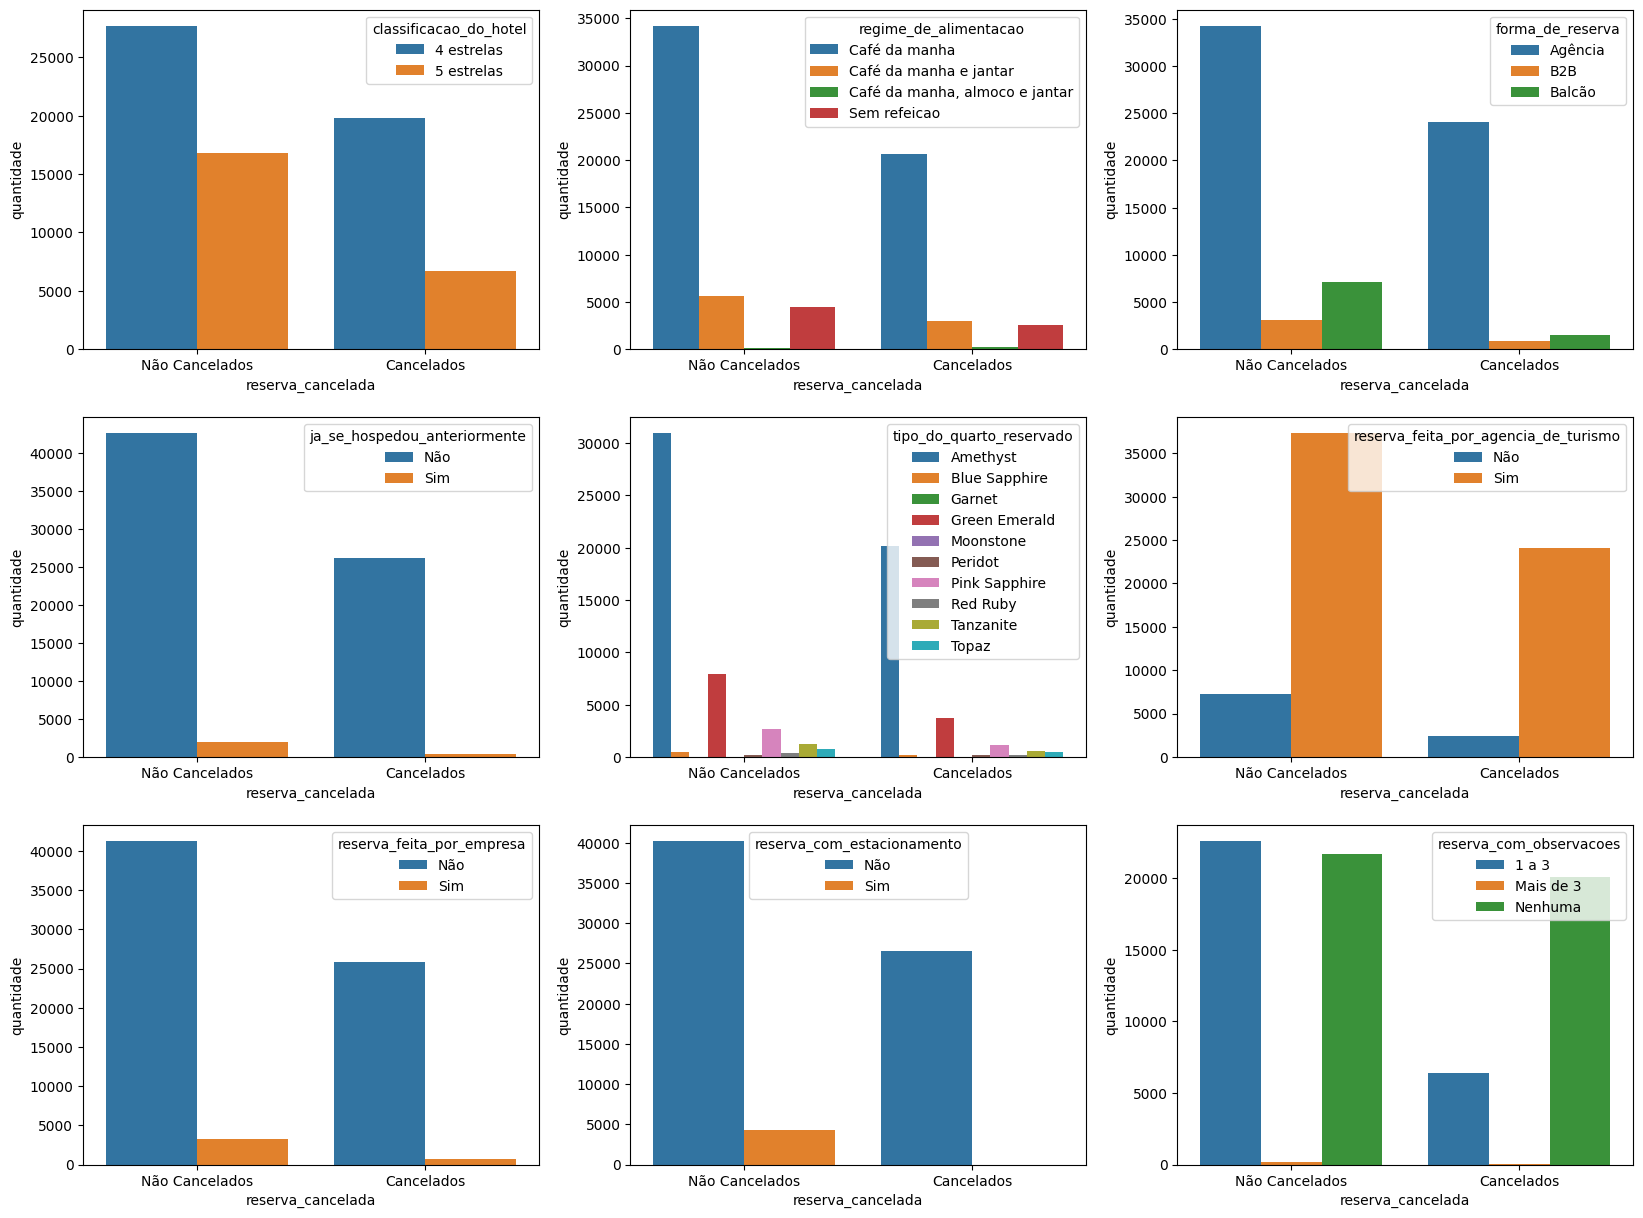

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
# plt.subplots_adjusts(wspace=1, hspace=1)

# classificacao_do_hotel
aux1 = df1[['classificacao_do_hotel', 'reserva_cancelada', 'id']].groupby(['classificacao_do_hotel', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='classificacao_do_hotel', data=aux1, ax=axs[0, 0]); # 0 = não cencelado ; 1 = cancelado
axs[0, 0].set_ylabel('quantidade');
axs[0, 0].set_xticklabels(['Não Cancelados', 'Cancelados']);

# regime_de_alimentacao
aux1 = df1[['regime_de_alimentacao', 'reserva_cancelada', 'id']].groupby(['regime_de_alimentacao', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='regime_de_alimentacao', data=aux1, ax=axs[0, 1]); # 0 = não cencelado ; 1 = cancelado
axs[0, 1].set_ylabel('quantidade');
axs[0, 1].set_xticklabels(['Não Cancelados', 'Cancelados']);

# forma_de_reserva
aux1 = df1[['forma_de_reserva', 'reserva_cancelada', 'id']].groupby(['forma_de_reserva', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='forma_de_reserva', data=aux1, ax=axs[0, 2]); # 0 = não cencelado ; 1 = cancelado
axs[0, 2].set_ylabel('quantidade');
axs[0, 2].set_xticklabels(['Não Cancelados', 'Cancelados']);

# ja_se_hospedou_anteriormente
aux1 = df1[['ja_se_hospedou_anteriormente', 'reserva_cancelada', 'id']].groupby(['ja_se_hospedou_anteriormente', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='ja_se_hospedou_anteriormente', data=aux1, ax=axs[1, 0]); # 0 = não cencelado ; 1 = cancelado
axs[1, 0].set_ylabel('quantidade');
axs[1, 0].set_xticklabels(['Não Cancelados', 'Cancelados']);

# tipo_do_quarto_reservado
aux1 = df1[['tipo_do_quarto_reservado', 'reserva_cancelada', 'id']].groupby(['tipo_do_quarto_reservado', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='tipo_do_quarto_reservado', data=aux1, ax=axs[1, 1]); # 0 = não cencelado ; 1 = cancelado
axs[1, 1].set_ylabel('quantidade');
axs[1, 1].set_xticklabels(['Não Cancelados', 'Cancelados']);

# reserva_feita_por_agencia_de_turismo
aux1 = df1[['reserva_feita_por_agencia_de_turismo', 'reserva_cancelada', 'id']].groupby(['reserva_feita_por_agencia_de_turismo', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='reserva_feita_por_agencia_de_turismo', data=aux1, ax=axs[1, 2]); # 0 = não cencelado ; 1 = cancelado
axs[1, 2].set_ylabel('quantidade');
axs[1, 2].set_xticklabels(['Não Cancelados', 'Cancelados']);

# reserva_feita_por_empresa
aux1 = df1[['reserva_feita_por_empresa', 'reserva_cancelada', 'id']].groupby(['reserva_feita_por_empresa', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='reserva_feita_por_empresa', data=aux1, ax=axs[2, 0]); # 0 = não cencelado ; 1 = cancelado
axs[2, 0].set_ylabel('quantidade');
axs[2, 0].set_xticklabels(['Não Cancelados', 'Cancelados']);

# reserva_com_estacionamento
aux1 = df1[['reserva_com_estacionamento', 'reserva_cancelada', 'id']].groupby(['reserva_com_estacionamento', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='reserva_com_estacionamento', data=aux1, ax=axs[2, 1]); # 0 = não cencelado ; 1 = cancelado
axs[2, 1].set_ylabel('quantidade');
axs[2, 1].set_xticklabels(['Não Cancelados', 'Cancelados']);

# reserva_com_observacoes
aux1 = df1[['reserva_com_observacoes', 'reserva_cancelada', 'id']].groupby(['reserva_com_observacoes', 'reserva_cancelada']).count().reset_index()
sns.barplot(x='reserva_cancelada', y='id', hue='reserva_com_observacoes', data=aux1, ax=axs[2, 2]); # 0 = não cencelado ; 1 = cancelado
axs[2, 2].set_ylabel('quantidade');
axs[2, 2].set_xticklabels(['Não Cancelados', 'Cancelados']);

# 2.0. FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1. Criação das hipóteses

1) Quanto maior o tempo entre a reserva e a data de check-in maior o cancelamento.
2) Quanto menor o número de pernoites reservadas maior o cancelamento.
3) Quanto menor o número de hóspedes maior o cancelamento.
4) Hóspedes de outros países (fora da Espanha) tendem a cancelar mais as reservas.
5) Reservas feitas por empresas tendem a ser menos canceladas.
6) Reservas feitas em hotéis com melhor avaliação tendem ser menos canceladas.

## 2.2. Feature Engineering

Nesse primeiro ciclo não criaremos novas features.

# 3.0. FILTRAGEM DAS VARIÁVEIS

In [16]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [17]:
# removeremos as linhas com numero_de_pernoites_reservadas igual a 0
df3.drop(df3[df3['numero_de_pernoites_reservadas'] == 0].index, inplace=True)

# removeremos as linhas com numero_de_hospedes igual a 0
df3.drop(df3[df3['numero_de_hospedes'] == 0].index, inplace=True)

## 3.2. Filtragem das Colunas

Não removeremos nenhuma das colunas nesse primeiro ciclo.

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [18]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

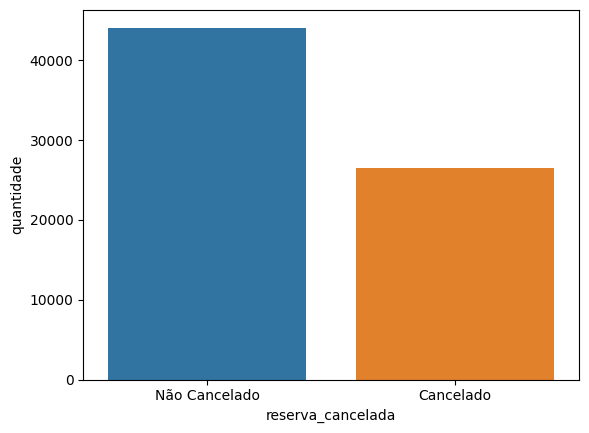

In [19]:
aux1 = df4[['reserva_cancelada', 'id']].groupby('reserva_cancelada').count().reset_index()
a = sns.barplot(x='reserva_cancelada', y='id', data=aux1);
a.set_ylabel('quantidade');
a.set_xticklabels(['Não Cancelado', 'Cancelado']);

### 4.1.2. Variáveis Numéricas

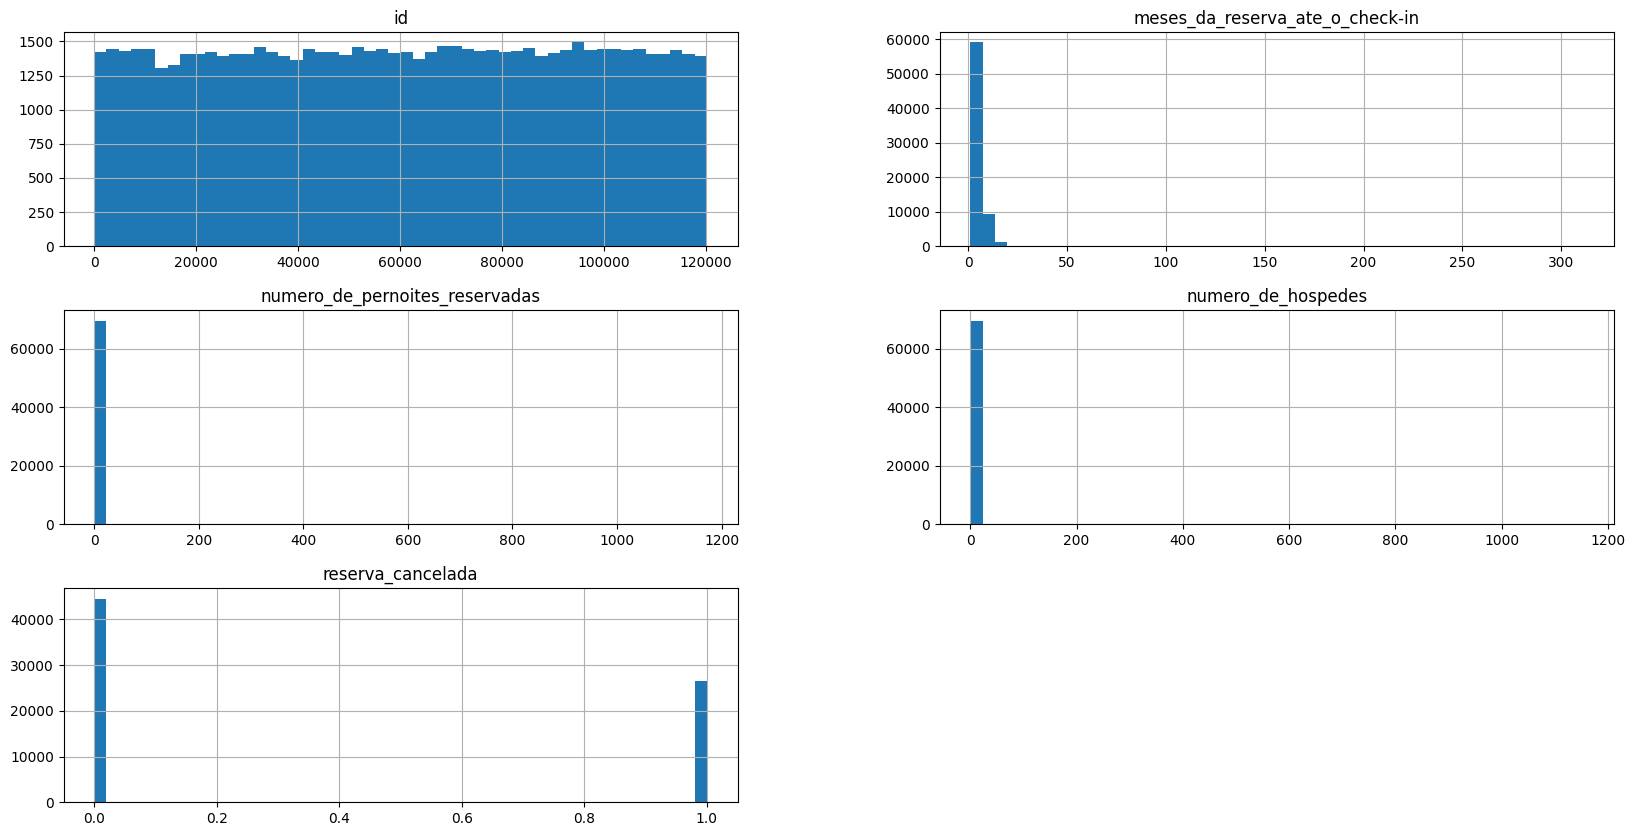

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
num_attributes.hist(bins=50, ax=axs);

### 4.1.3. Variáveis Categóricas

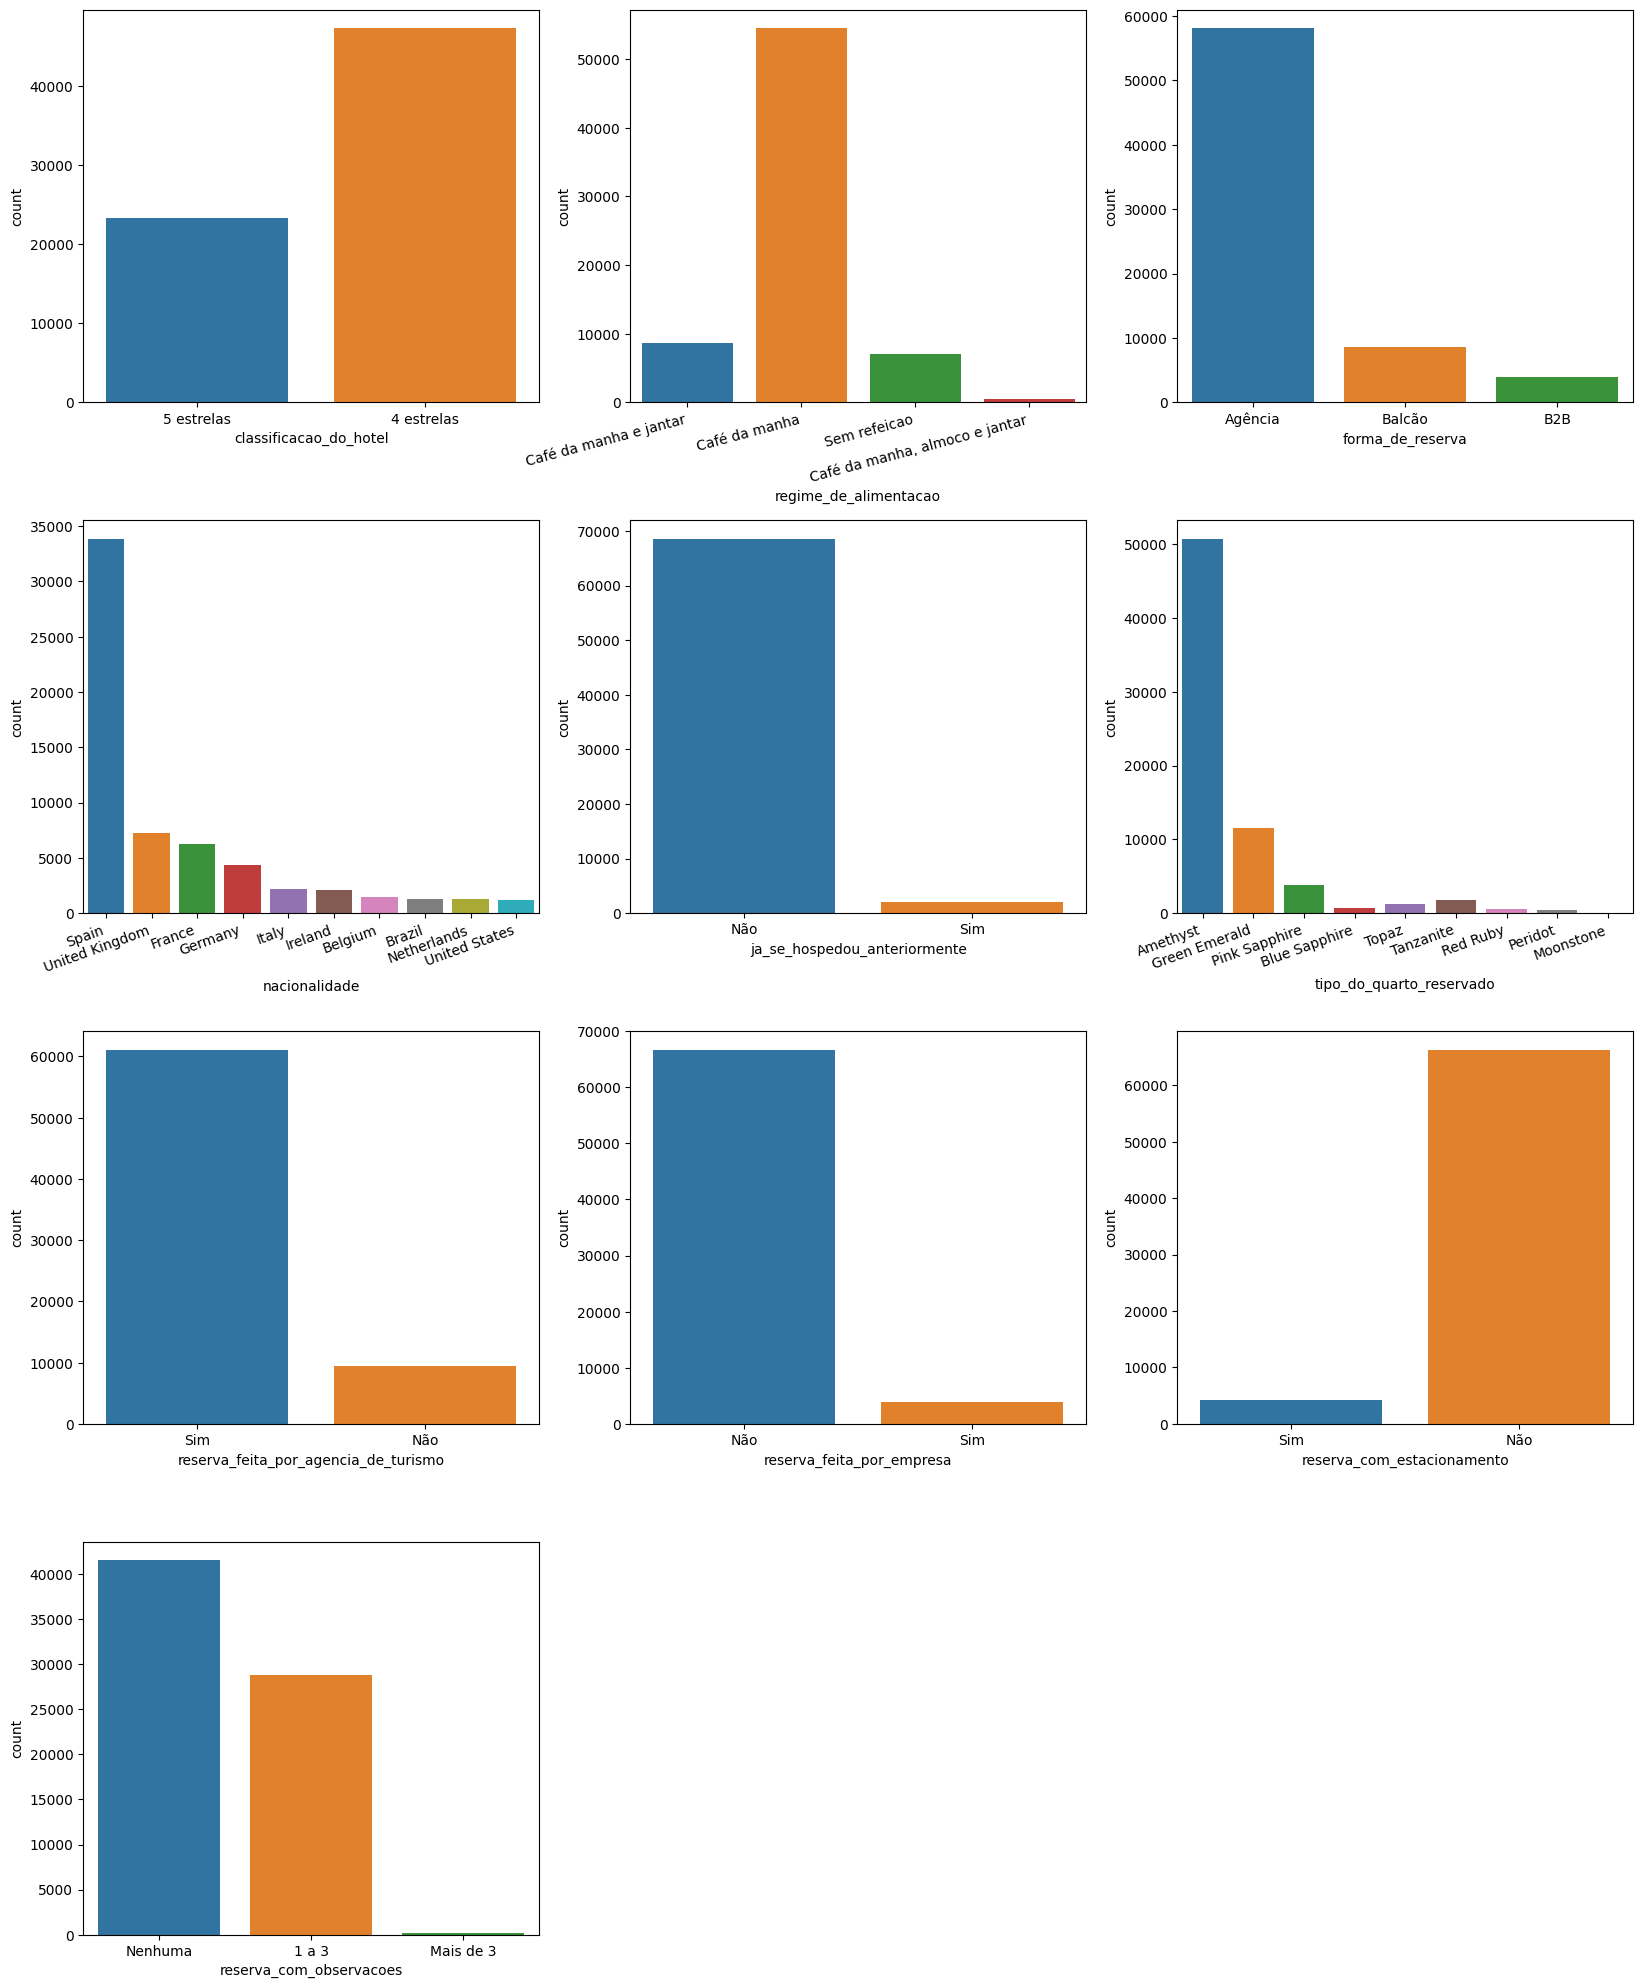

In [21]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 25), gridspec_kw={'wspace': 0.2, 'hspace': 0.3})

# classificacao_do_hotel
sns.countplot(x='classificacao_do_hotel', data=df4, ax=axs[0, 0]);

# regime_de_alimentacao
sns.countplot(x='regime_de_alimentacao', data=df4, ax=axs[0, 1]);
axs[0, 1].set_xticklabels(df4['regime_de_alimentacao'].unique(), rotation=15, ha='right');

# forma_de_reserva
sns.countplot(x='forma_de_reserva', data=df4, ax=axs[0, 2]);

# nacionalidade
# filtrando países com mais de 1000 reservas
aux1 = df4[['nacionalidade', 'id']].groupby('nacionalidade').count().sort_values('id', ascending=False).reset_index()
aux1.columns=['nacionalidade', 'count']
aux2 = aux1[aux1['count'] > 1000]
sns.barplot(x='nacionalidade', y='count', data=aux2, ax=axs[1, 0]);
axs[1, 0].set_xticklabels(aux2['nacionalidade'], rotation=20, ha='right');

# ja_se_hospedou_anteriormente
sns.countplot(x='ja_se_hospedou_anteriormente', data=df4, ax=axs[1, 1]);

# tipo_do_quarto_reservado
sns.countplot(x='tipo_do_quarto_reservado', data=df4, ax=axs[1, 2]);
axs[1, 2].set_xticklabels(df4['tipo_do_quarto_reservado'].unique(), rotation=20, ha='right');

# reserva_feita_por_agencia_de_turismo
sns.countplot(x='reserva_feita_por_agencia_de_turismo', data=df4, ax=axs[2, 0]);

# reserva_feita_por_empresa
sns.countplot(x='reserva_feita_por_empresa', data=df4, ax=axs[2, 1]);

# reserva_com_estacionamento
sns.countplot(x='reserva_com_estacionamento', data=df4, ax=axs[2, 2]);

# reserva_com_observacoes
sns.countplot(x='reserva_com_observacoes', data=df4, ax=axs[3, 0]);

# Remova o segundo espaço do subplot
fig.delaxes(axs[3, 1])
fig.delaxes(axs[3, 2])

## 4.2. Análise Bivariada

##### **H1. Quanto maior o tempo entre a reserva e a data de check-in maior o cancelamento.**<br>
**Falso**, como podemos observar no gráfico abaixo, não há um aumento nos cancelamentos ao longo devido ao maior tempo de reservas.<br>
Também podemos observar que as reservas com mais de 12 meses de antecedência são irrisórias quando comparado às reservas feitas dentro de 01 ano.<br>
No caso, seria interessante estudar como melhorar a retenção das reservas feitas com até 12 meses de antecedência.

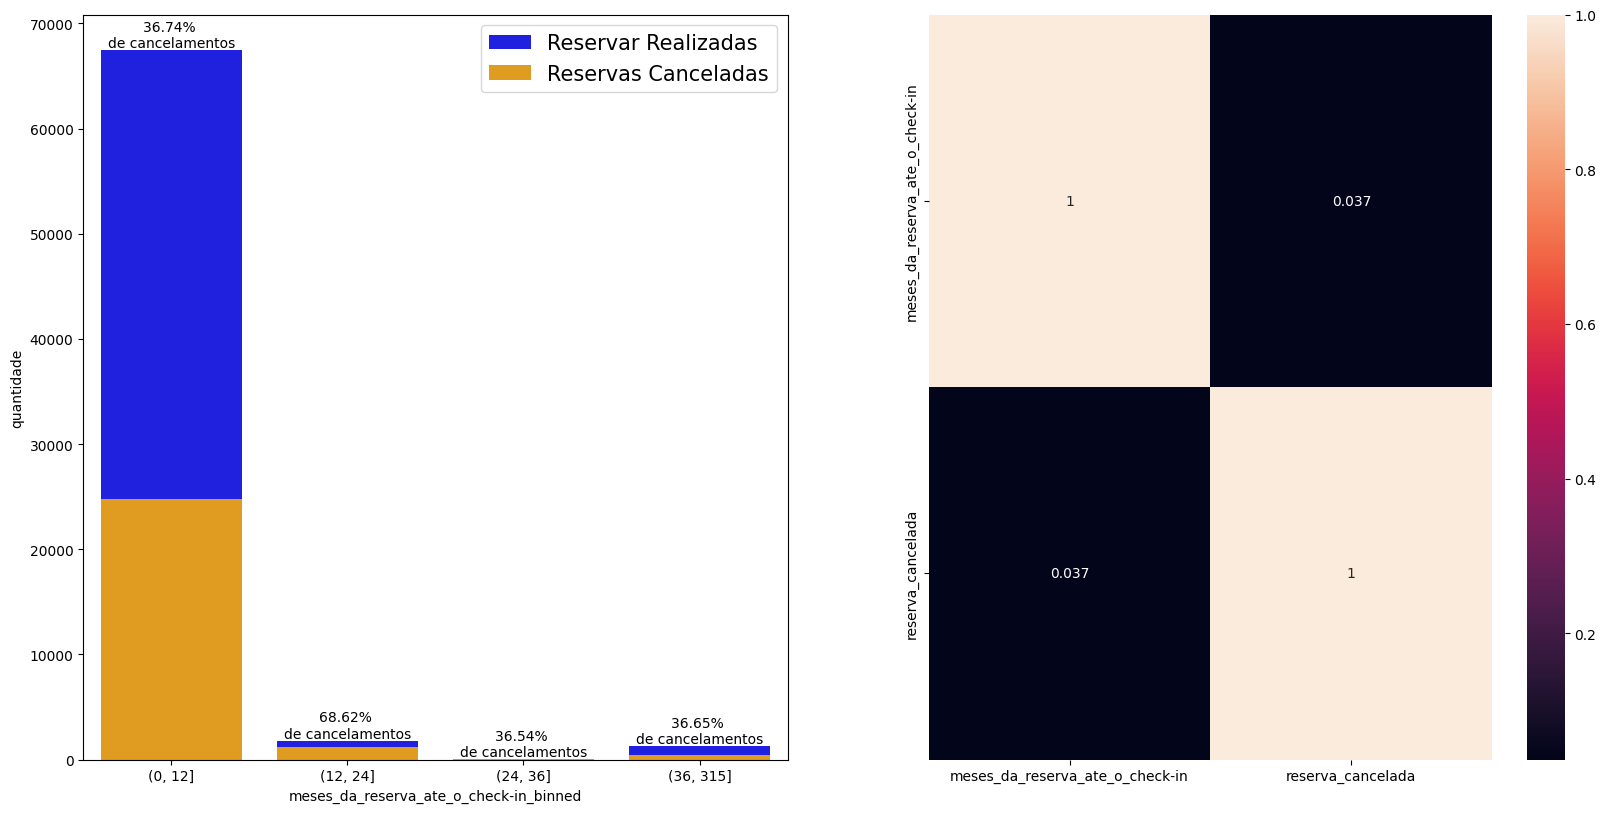

In [22]:
# contando a quantidade de cada 'meses_da_reserva_ate_o_check-in'
aux1 = df4[['meses_da_reserva_ate_o_check-in', 'id']].groupby('meses_da_reserva_ate_o_check-in').count().reset_index().rename(columns={'id': 'quantidade'})

# somando as 'reserva_canceladas = 1' para cada 'meses_da_reserva_ate_o_check-in'
aux2 = df4[['meses_da_reserva_ate_o_check-in', 'reserva_cancelada']].groupby('meses_da_reserva_ate_o_check-in').sum().reset_index()

# construindo dataframe que será utilizado na construção do gráfico
aux3 = pd.merge(aux1, aux2, on='meses_da_reserva_ate_o_check-in')
# dividindo em bins
bins = [0, 12, 24, 36, 315]
aux3['meses_da_reserva_ate_o_check-in_binned'] = pd.cut(aux3['meses_da_reserva_ate_o_check-in'], bins).astype(str)
# somando as reservas e reservas canceladas para cada bin
aux3 = aux3[['meses_da_reserva_ate_o_check-in_binned', 'quantidade', 'reserva_cancelada']].groupby('meses_da_reserva_ate_o_check-in_binned').sum().reset_index()
# calculando a taxa de cancelamento
aux3['taxa_de_cancelamento'] = aux3.apply(lambda x: '{:.2f}% \nde cancelamentos'.format((x['reserva_cancelada'] / x['quantidade']) * 100), axis=1)

# criação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x='meses_da_reserva_ate_o_check-in_binned', y='quantidade', data=aux3, ax=axs[0], color='blue', label='Reservar Realizadas');
sns.barplot(x='meses_da_reserva_ate_o_check-in_binned', y='reserva_cancelada', data=aux3, ax=axs[0], color='orange', label='Reservas Canceladas');

for i in range(len(aux3['meses_da_reserva_ate_o_check-in_binned'])):
    axs[0].text(aux3.index[i], aux3['quantidade'][i], aux3['taxa_de_cancelamento'][i], ha='center', va='bottom')

axs[0].legend(fontsize='15');
axs[0].set_ylabel('quantidade');
plt.subplots_adjust(top=1.6);

sns.heatmap(df4[['meses_da_reserva_ate_o_check-in', 'reserva_cancelada']].corr(method='pearson'), annot=True);

##### **H2. Quanto menor o número de pernoites reservadas maior o cancelamento.**
**Falso**, a taxa de cancelamentos não aumenta conforme menor o número de pernoites.<br>
No entanto, observa-se que as reservas para 2 e 3 pernoites são a grande maioria e suas taxas de cancelamentos são bem altas, 44.25% e 41.75%, respectivamente.<br>
Tendo isso em vista, poderia-se estudar como aumentar a rentenção para reservas desse tipo.

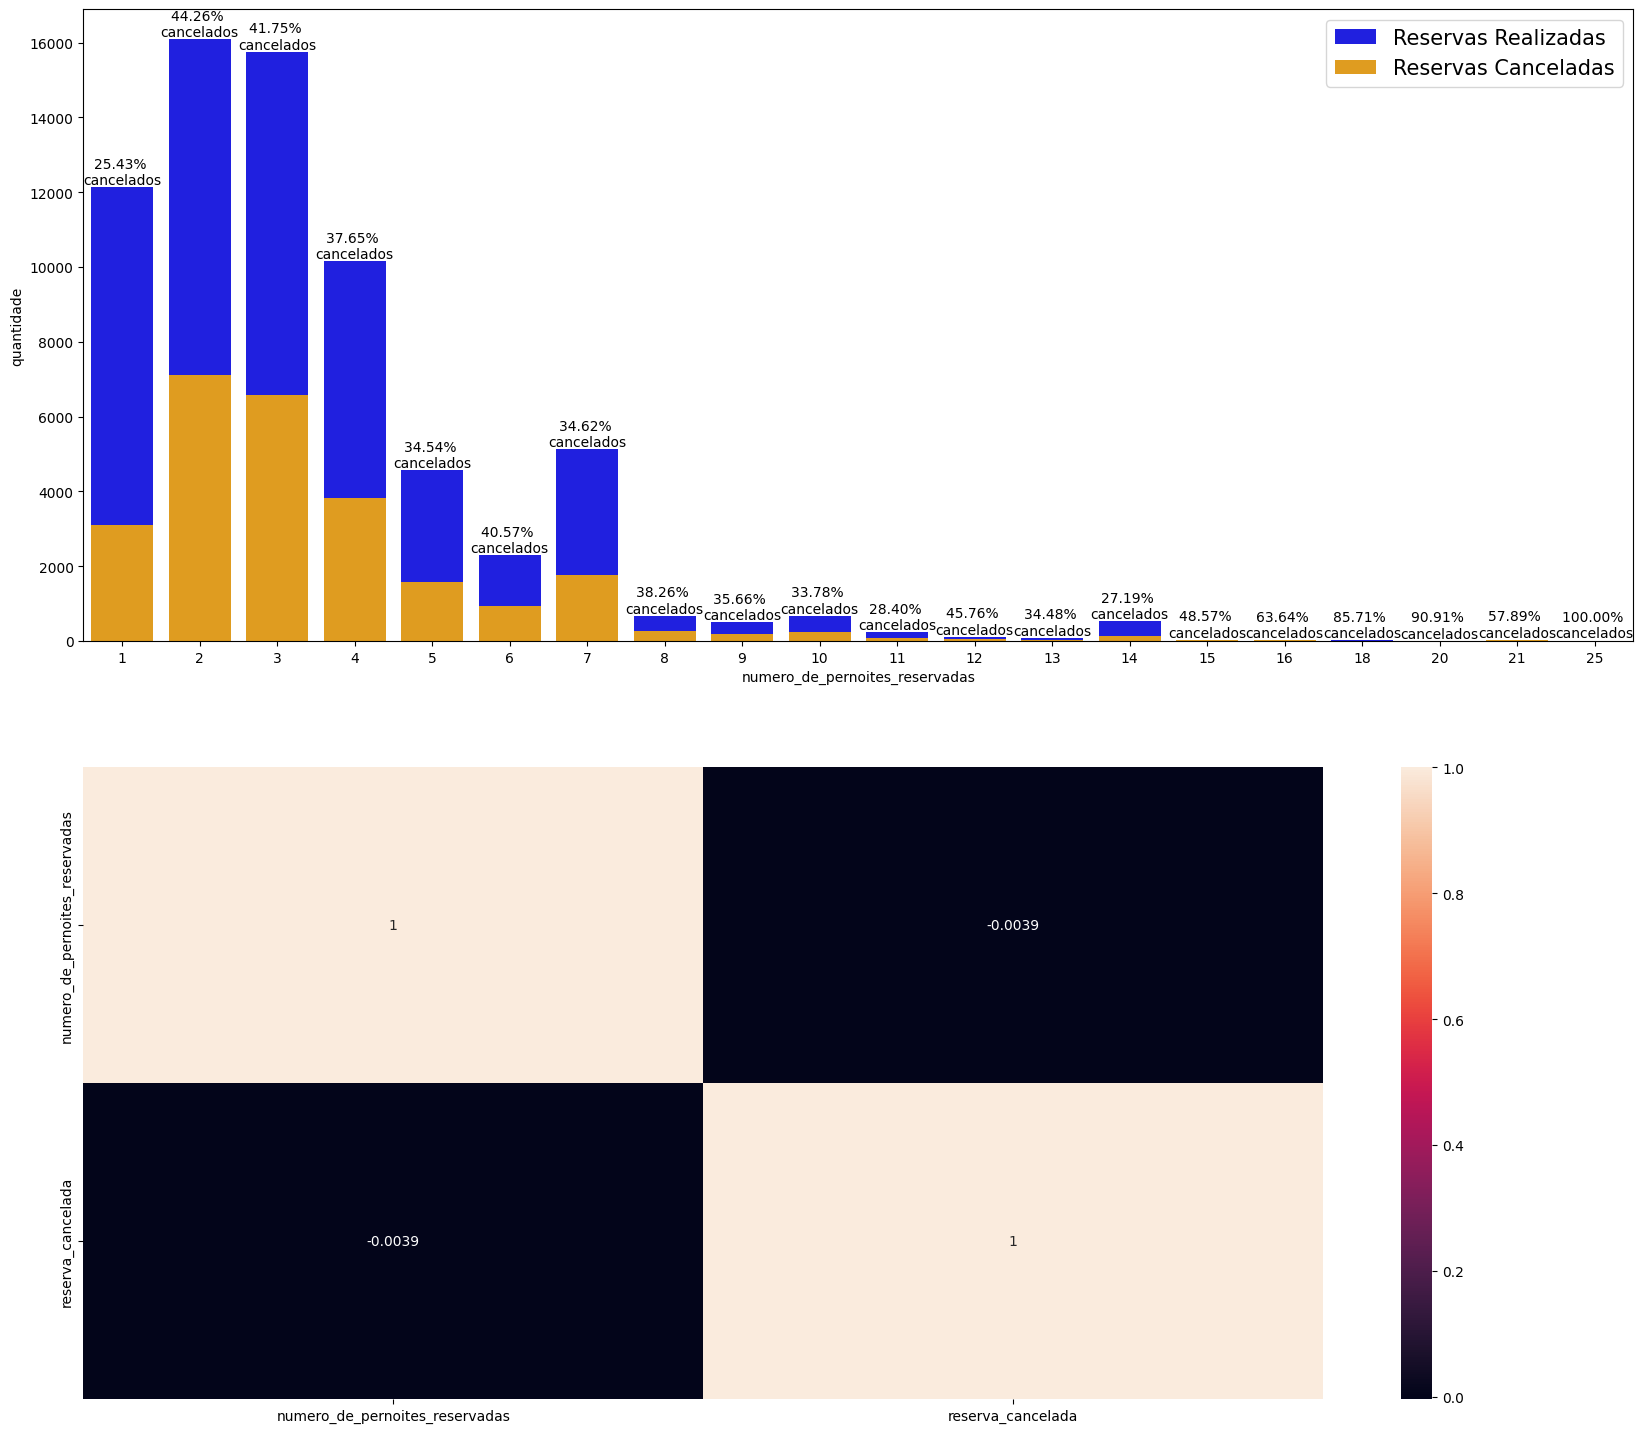

In [23]:
# contando a quantidade de reservas por 'numero_de_pernoites_reservadas'
aux1 = df4[['numero_de_pernoites_reservadas', 'id']].groupby('numero_de_pernoites_reservadas').count().reset_index().rename(columns={'id': 'quantidade'})
# somando a quantidade de 'reserva_cancelada = 1'
aux2 = df4[['numero_de_pernoites_reservadas', 'reserva_cancelada']].groupby('numero_de_pernoites_reservadas').sum().reset_index()

# criando o dataframe para montagem do gráfico
aux3 = pd.merge(aux1, aux2, on='numero_de_pernoites_reservadas')
aux3['taxa_de_cancelamento'] = aux3.apply(lambda x: '{:.2f}% \ncancelados'.format((x['reserva_cancelada'] / x['quantidade']) * 100), axis=1)

# limitando a análise para o mínimo de 10 cancelamentos
aux3 = aux3[aux3['reserva_cancelada'] >= 10].reset_index()

# criação do gráfico
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.barplot(x='numero_de_pernoites_reservadas', y='quantidade', data=aux3, ax=axs[0], color='blue', label='Reservas Realizadas');
sns.barplot(x='numero_de_pernoites_reservadas', y='reserva_cancelada', data=aux3, ax=axs[0], color='orange', label='Reservas Canceladas');

for i in range(len(aux3['numero_de_pernoites_reservadas'])):    
    axs[0].text(aux3.index[i], aux3['quantidade'][i], aux3['taxa_de_cancelamento'][i], ha='center', va='bottom');

axs[0].set_ylabel('quantidade');
axs[0].legend(fontsize='15');
plt.subplots_adjust(top=1.5)

sns.heatmap(df4[['numero_de_pernoites_reservadas', 'reserva_cancelada']].corr(method='pearson'), annot=True, ax=axs[1]);

##### **H3. Quanto menor o número de hóspedes maior o cancelamento.**
**Falso**, como pode-se observar, há menos cancelamento para uma pessoa do que para duas.<br>
Também é possível verificarmos que a grande maioria das reservas é feita por 'casais' (02 pessoas), e que a taxa de cancelamento é bem alta (40.20%).<br>
Por isso precisaremos estudar como aumentar a retenção quando a reserva for para essa quantia de hóspedes.

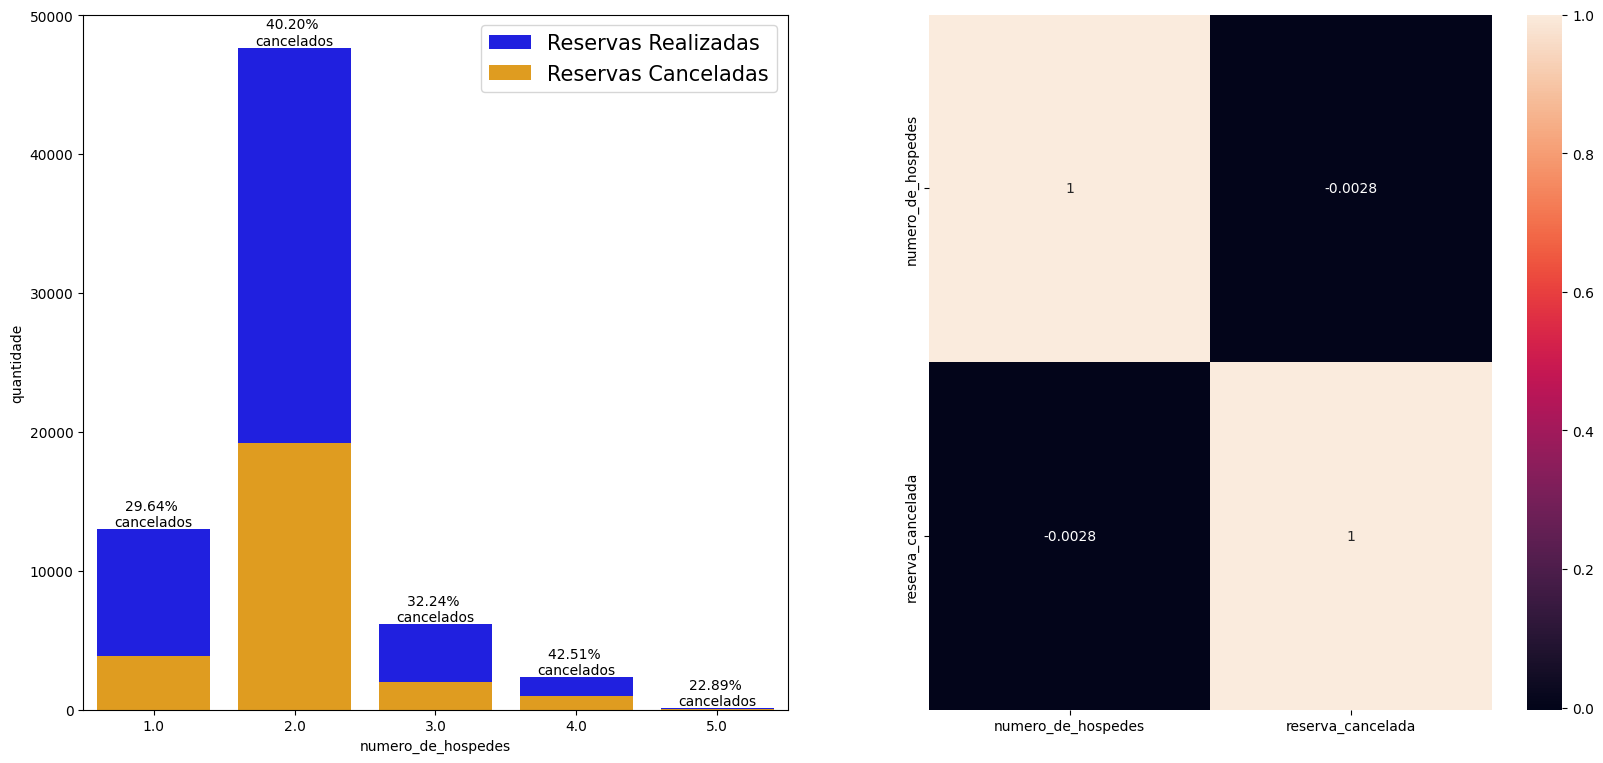

In [24]:
# contando a quantidade de reservas por 'numero_de_hospedes'
aux1 = df4[['numero_de_hospedes', 'id']].groupby('numero_de_hospedes').count().reset_index().rename(columns={'id': 'quantidade'})
# somando a quantidade de 'reserva_cancelada = 1'
aux2 = df4[['numero_de_hospedes', 'reserva_cancelada']].groupby('numero_de_hospedes').sum().reset_index()

# criando o dataframe para montagem do gráfico
aux3 = pd.merge(aux1, aux2, on='numero_de_hospedes')
aux3['taxa_de_cancelamento'] = aux3.apply(lambda x: '{:.2f}% \ncancelados'.format((x['reserva_cancelada']/x['quantidade']) * 100), axis=1)
# limitando a análise para o mínimo de 10 cancelamentos
aux3 = aux3[aux3['reserva_cancelada'] >= 10]

# criação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x='numero_de_hospedes', y='quantidade', data=aux3, ax=axs[0], color='blue', label='Reservas Realizadas');
sns.barplot(x='numero_de_hospedes', y='reserva_cancelada', data=aux3, ax=axs[0], color='orange', label='Reservas Canceladas');

for i in range(len(aux3['numero_de_hospedes'])):
    axs[0].text(aux3.index[i], aux3['quantidade'][i], aux3['taxa_de_cancelamento'][i], ha='center', va='bottom');

axs[0].set_ylabel('quantidade');
axs[0].legend(fontsize='15');
plt.subplots_adjust(top=1.5);

sns.heatmap(df4[['numero_de_hospedes', 'reserva_cancelada']].corr(method='pearson'), annot=True);

##### **H4. Hóspedes de outros países (fora da Espanha) tendem a cancelar mais as reservas.**
**Falso**, conforme observamos a taxa de cancelamentos de pessoas com nacionalidade 'Spain' cancelam mais do que a soma de todos os outros países juntos.<br>
Observamos que o cancelamento é muito expressivo (52.53%), sendo que a quantidade de reservas de Espanhóis e a soma das outras nacionalidades são quase iguais.<br>
Sendo assim, o próximo passo seria procurar modos de aumentar a retenção dos clientes Espanhóis.

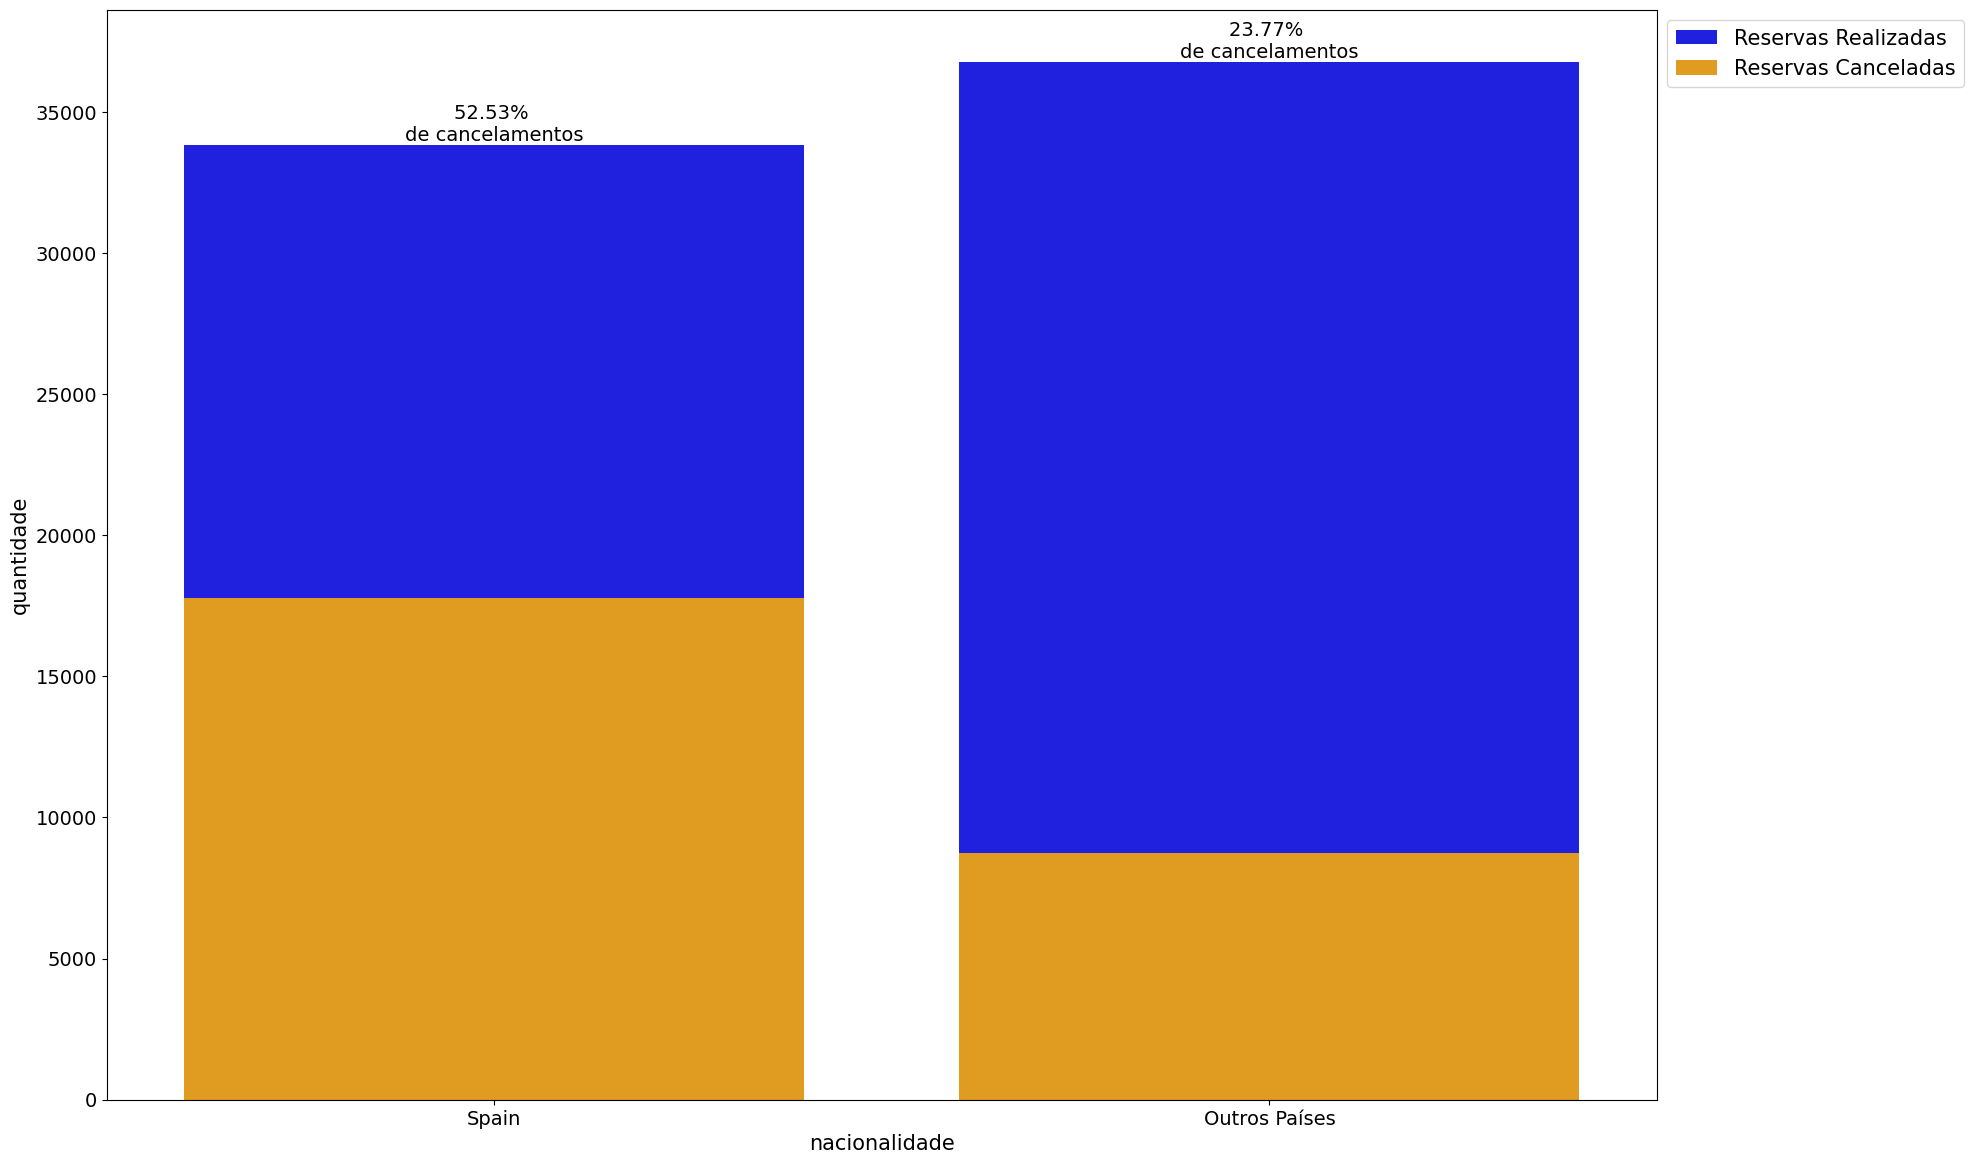

In [25]:
# contagem da quantidade de reservas por nacionalidade
aux1 = df4[['nacionalidade', 'id']].groupby('nacionalidade').count().reset_index().rename(columns={'id': 'quantidade'})
# soma da quantidade de cancelamentos por nacionalidade
aux2 = df4[['nacionalidade', 'reserva_cancelada']].groupby('nacionalidade').sum().reset_index()

# juntando os dataframes através da nacionalidade
aux3 = pd.merge(aux1, aux2, on='nacionalidade')

# separando a espanha dos demais países
spain = aux3[aux3['nacionalidade'] == 'Spain']
other_countries = pd.DataFrame(aux3[~(aux3['nacionalidade'] == 'Spain')].sum()).T
other_countries['nacionalidade'][0] = 'Outros Países'

# criando dataframe para montagem do gráfico
aux4 = pd.concat([spain, other_countries]).reset_index(drop=True)
aux4['taxa_de_cancelamento'] = aux4.apply(lambda x: '{:.2f}% \nde cancelamentos'.format((x['reserva_cancelada'] / x['quantidade']) * 100), axis=1)

# criação do gráfico
fig, axs = plt.subplots(figsize=(20, 10))

sns.barplot(x='nacionalidade', y='quantidade', data=aux4, ax=axs, color='blue', label='Reservas Realizadas');
sns.barplot(x='nacionalidade', y='reserva_cancelada', data=aux4, ax=axs, color='orange', label='Reservas Canceladas');

for i in range(len(aux4['nacionalidade'])):
    axs.text(aux4.index[i], aux4['quantidade'][i], aux4['taxa_de_cancelamento'][i], ha='center', va='bottom', fontsize='14');

# aumentando tamanho das fontes eixo x
axs.set_xticklabels(aux4['nacionalidade'], fontsize='14');
axs.set_xlabel('nacionalidade', fontsize=15);

# aumentando tamanho das fontes eixo y
axs.yaxis.set_tick_params(labelsize=14);
axs.set_ylabel('quantidade', fontsize=15);

# posicionando a legenda fora do gráfico
axs.legend(fontsize='15', bbox_to_anchor=(1, 1));
plt.subplots_adjust(top=1.2);

##### **H5. Reservas feitas por empresas tendem a ser menos canceladas.**
**Verdadeiro**, observamos no gráfico que as reservas feitas por empresas tem uma taxa de cancelamento menor.

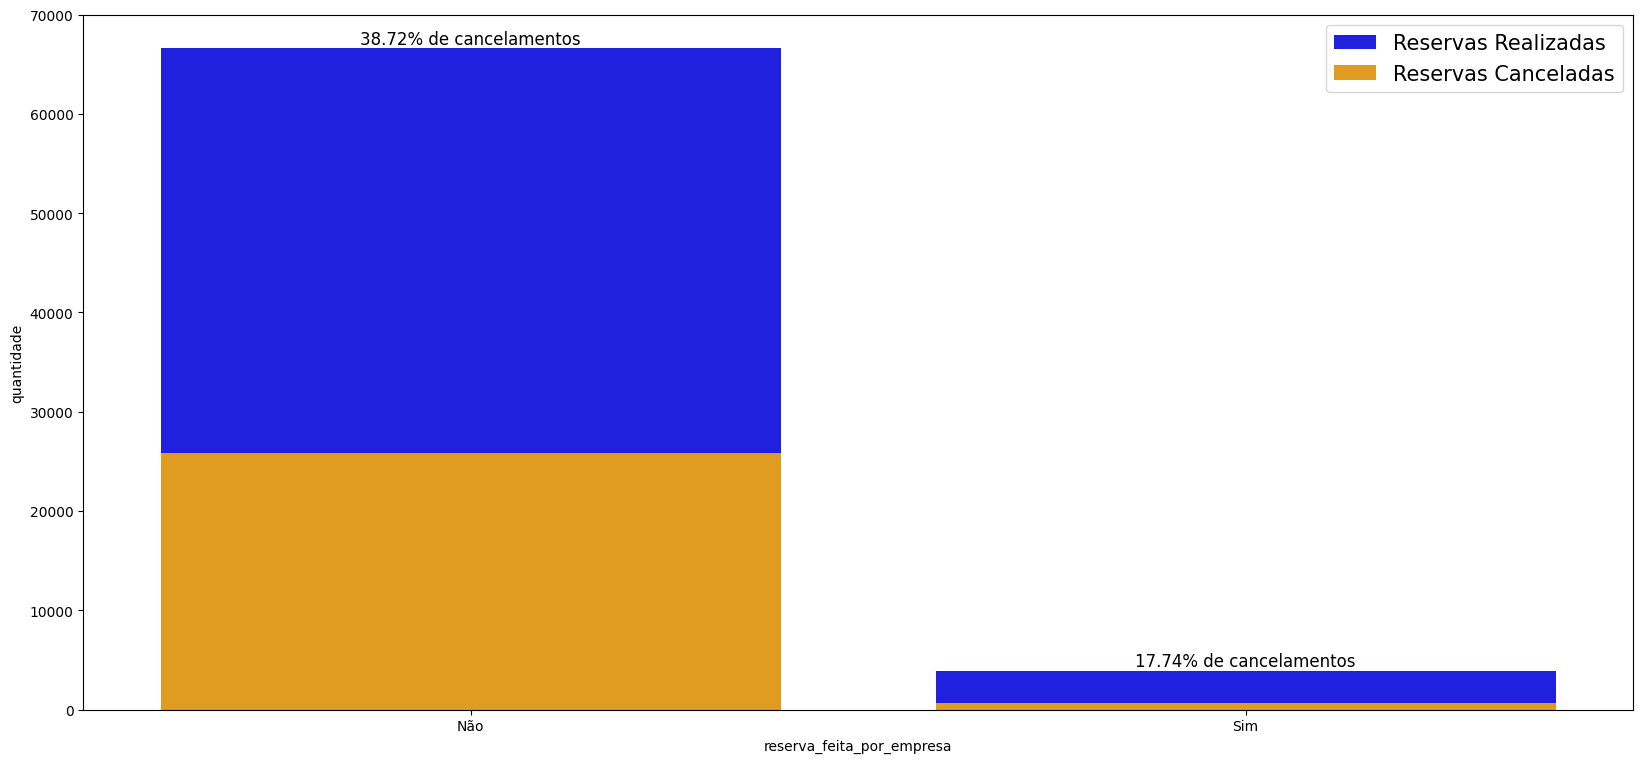

In [26]:
# contagem da quantidade de reservas feitas por empresa
aux1 = df4[['reserva_feita_por_empresa', 'id']].groupby('reserva_feita_por_empresa').count().reset_index().rename(columns={'id': 'quantidade'})
# soma da quantidade de cancelamentos feitos pelas empresas
aux2 = df4[['reserva_feita_por_empresa','reserva_cancelada']].groupby('reserva_feita_por_empresa').sum().reset_index()

# criação do dataframe para montagem do gráfico
aux3 = pd.merge(aux1, aux2, on='reserva_feita_por_empresa')
aux3['taxa_de_cancelamento'] = aux3.apply(lambda x: '{:.2f}% de cancelamentos'.format((x['reserva_cancelada'] / x['quantidade'])* 100), axis=1)

# criação do gráfico
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

sns.barplot(x='reserva_feita_por_empresa', y='quantidade', data=aux3, ax=axs, color='blue', label='Reservas Realizadas');
sns.barplot(x='reserva_feita_por_empresa', y='reserva_cancelada', data=aux3, ax=axs, color='orange', label='Reservas Canceladas');

for i in range(len(aux3['reserva_feita_por_empresa'])):
    axs.text(aux3.index[i], aux3['quantidade'][i], aux3['taxa_de_cancelamento'][i], ha='center', va='bottom', fontsize=12);

axs.set_ylabel('quantidade');
axs.legend(fontsize=15);
plt.subplots_adjust(top=1.5);

##### **H6. Reservas feitas em hotéis com melhor avaliação tendem ser menos canceladas.**
**Verdadeiro**, conforme observamos no gráfico a taxa de cancelamento nos hotéis 5 estrelas são bem menores.<br>
Um próximo passo seria investigar o motivo da grande diferença entre as taxas de retenção para podermos recomendar melhorias.

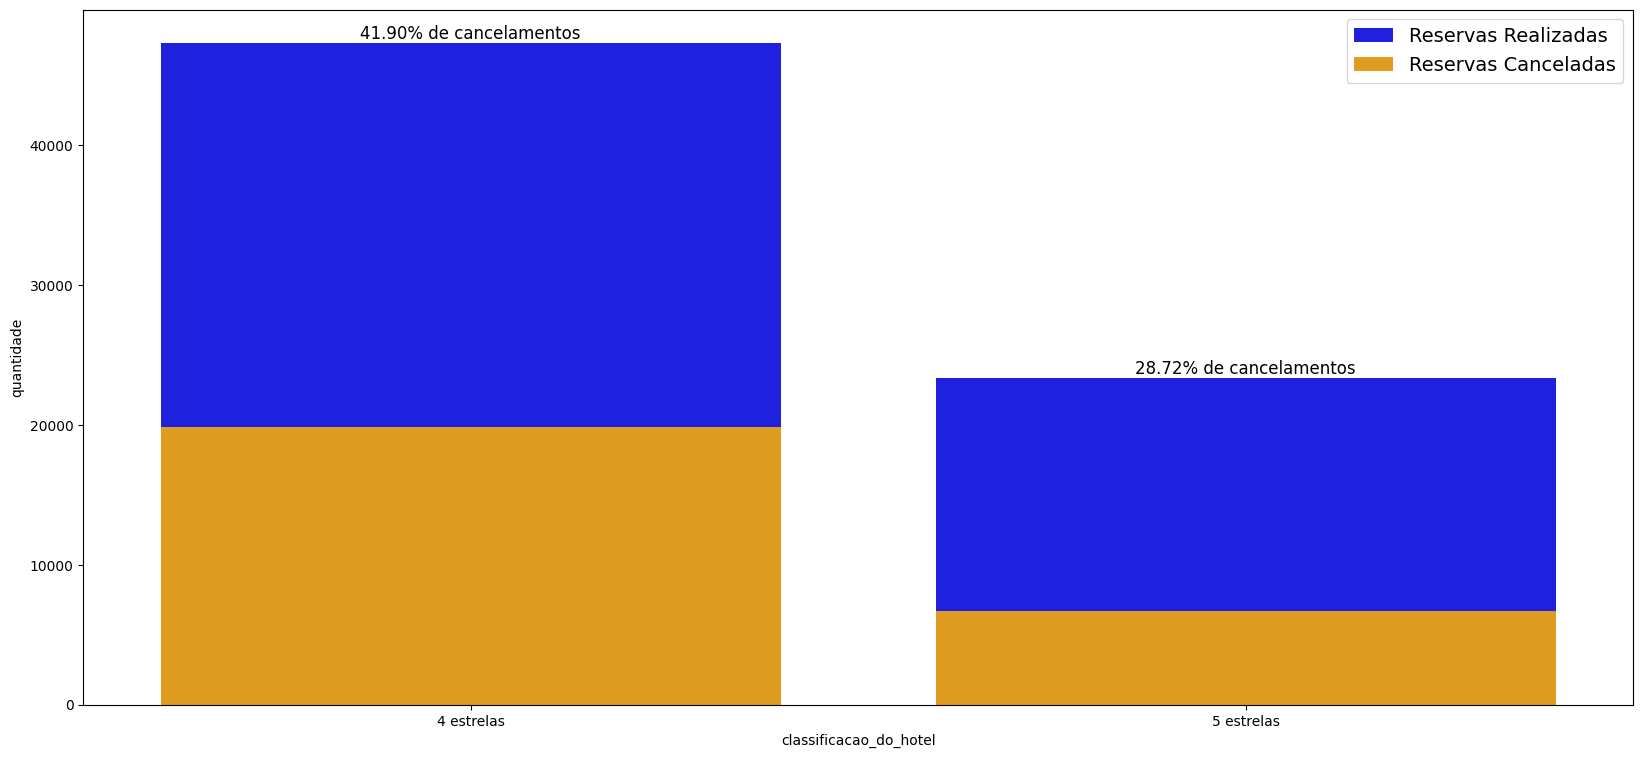

In [27]:
# contagem da quantidade de reservas feitas por classificação
aux1 = df4[['classificacao_do_hotel', 'id']].groupby('classificacao_do_hotel').count().reset_index().rename(columns={'id':'quantidade'})
# soma da quantidade de cancelamentos realizados por classificação
aux2 = df4[['classificacao_do_hotel', 'reserva_cancelada']].groupby('classificacao_do_hotel').sum().reset_index()

# criação do dataframe para montagemdo gráfico
aux3 = pd.merge(aux1, aux2, on='classificacao_do_hotel')
aux3['taxa_de_cancelamento'] = aux3.apply(lambda x: '{:.2f}% de cancelamentos'.format((x['reserva_cancelada'] / x['quantidade']) * 100), axis=1)

# criação do gráfico
fig, axs = plt.subplots(1, 1, figsize=(20, 5))

sns.barplot(x='classificacao_do_hotel', y='quantidade', data=aux3, ax=axs, color='blue', label='Reservas Realizadas');
sns.barplot(x='classificacao_do_hotel', y='reserva_cancelada', data=aux3, ax=axs, color='orange', label='Reservas Canceladas');

for i in range(len(aux3['classificacao_do_hotel'])):
    axs.text(aux3.index[i], aux3['quantidade'][i], aux3['taxa_de_cancelamento'][i], ha='center', va='bottom', fontsize=12);

axs.set_ylabel('quantidade');
axs.legend(fontsize=14);
plt.subplots_adjust(top=1.5);

##### Resumo das Hipóteses

In [28]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Baixa'],
       ['H4', 'Falsa', 'Média'],
       ['H5', 'Verdadeira', 'Média'],
       ['H6', 'Verdadeira', 'Média']]

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Média
H5           Verdadeira   Média
H6           Verdadeira   Média


## 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

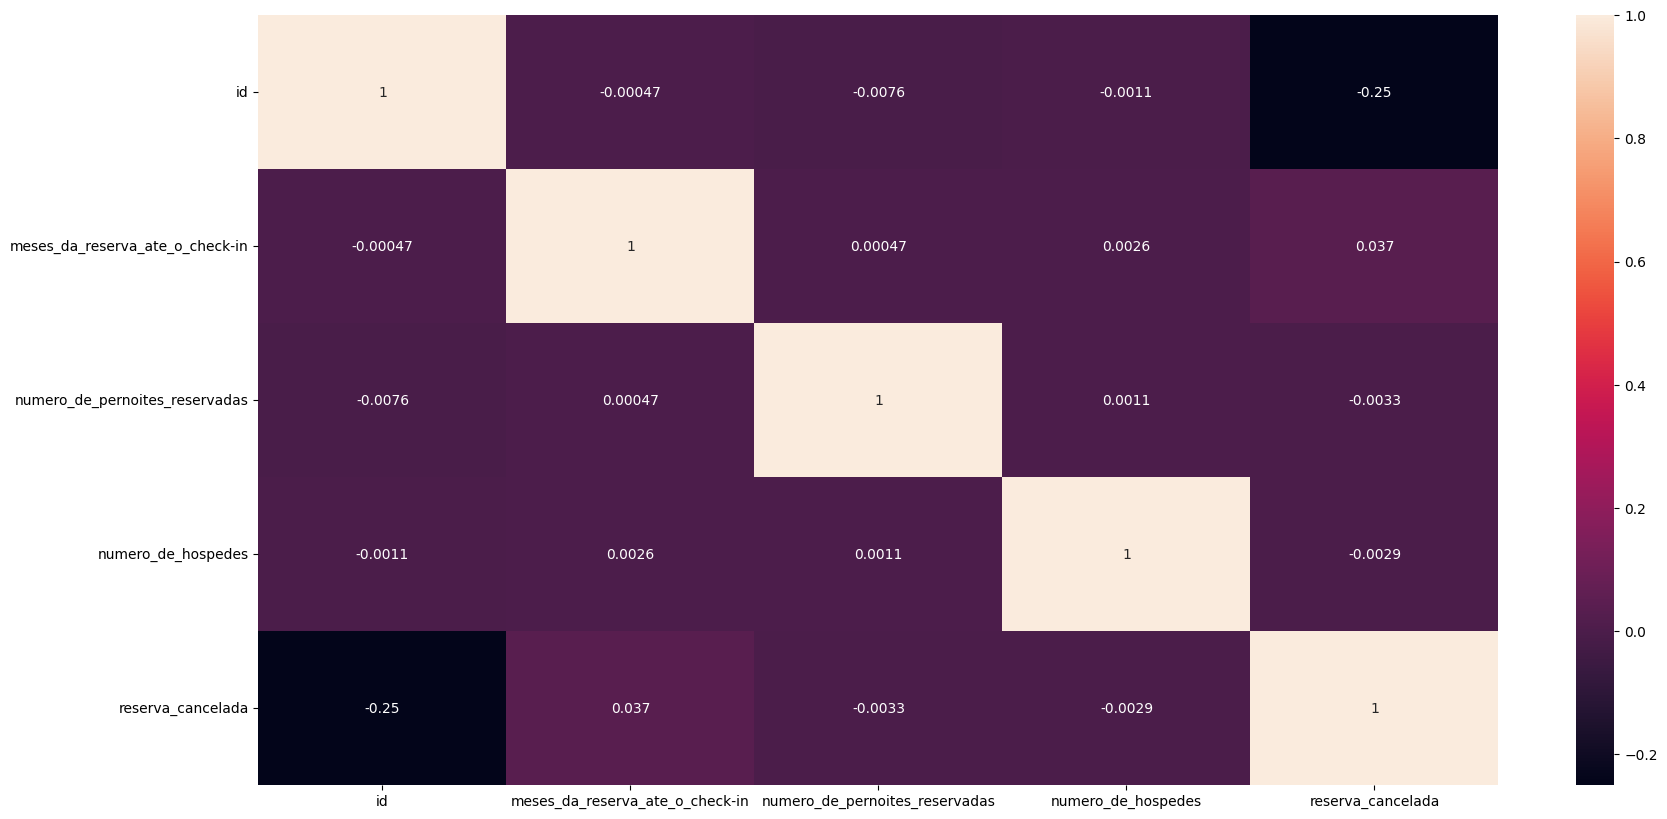

In [29]:
fig, axs = plt.subplots(figsize=(20, 10))

corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True, ax=axs);

### 4.3.2. Atributos Categóricos

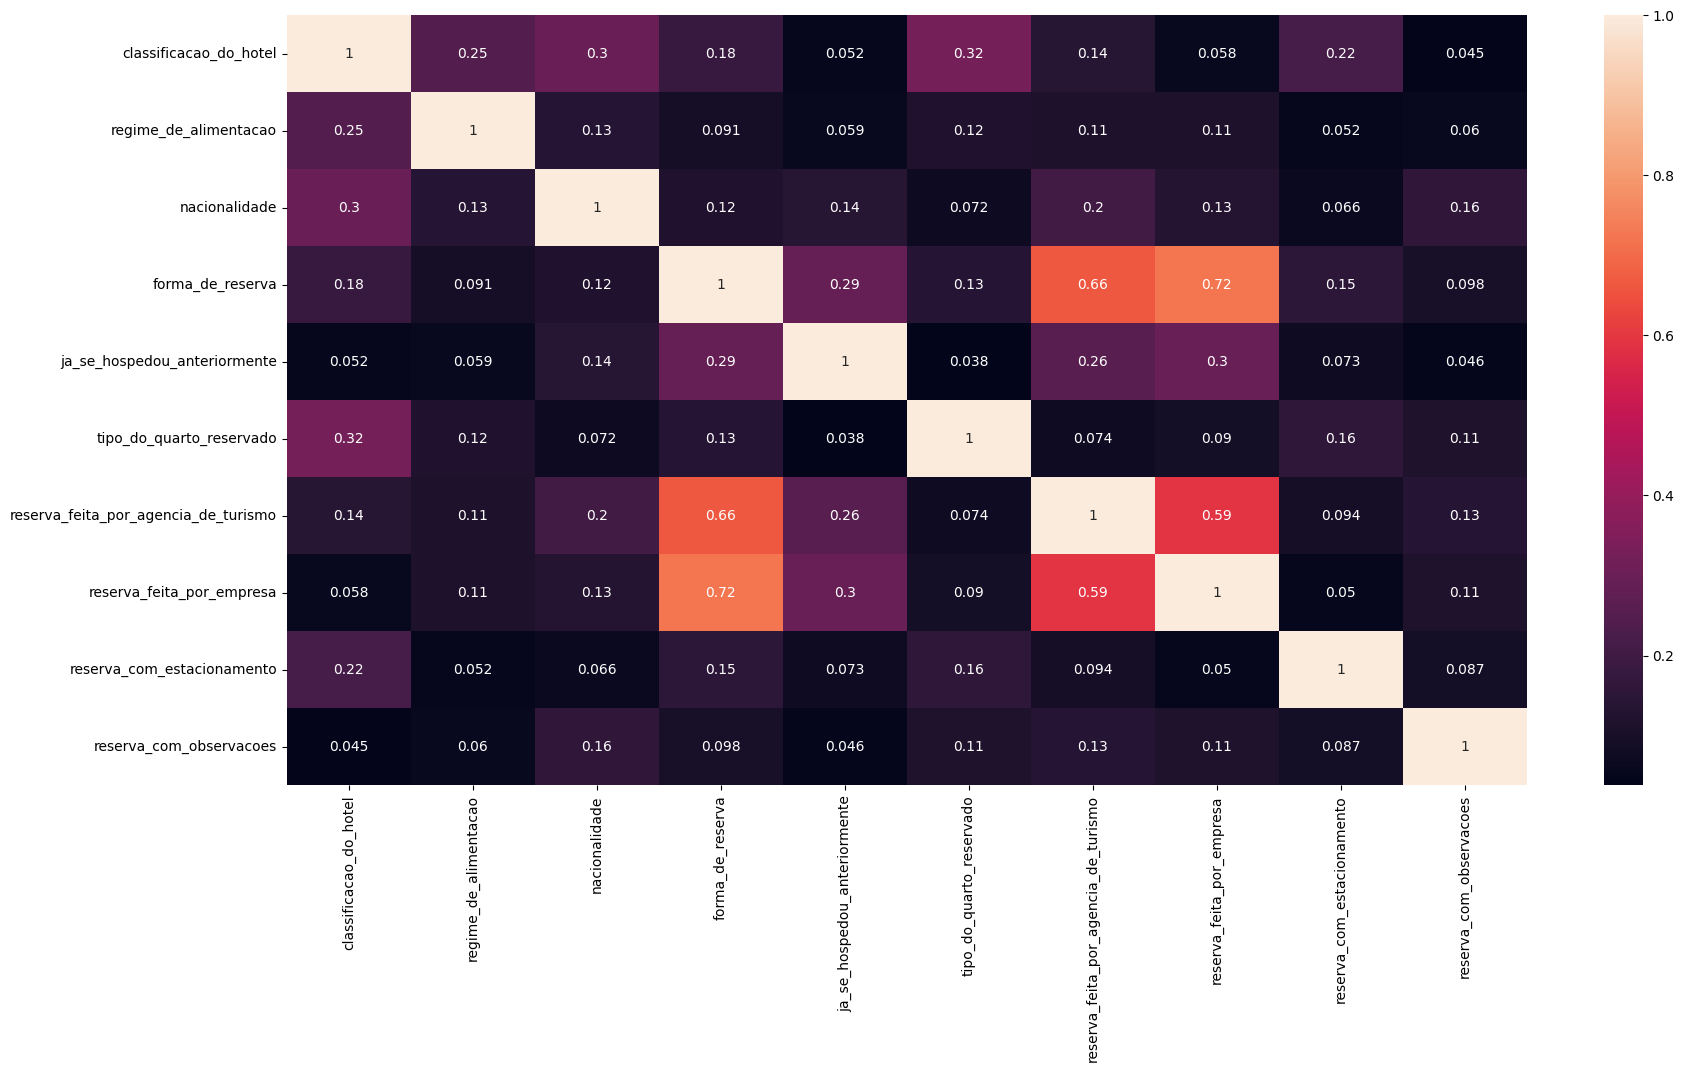

In [30]:
data = pd.DataFrame(columns=cat_attributes.columns)

for i in range(data.columns.shape[0]):
    for j in range(cat_attributes.columns.shape[0]):
        data.loc[j, data.columns[i]] = cramers_v(cat_attributes[cat_attributes.columns[i]], 
                                             cat_attributes[cat_attributes.columns[j]])

data = data.astype('float64')
data.set_index(data.columns, inplace=True)

fig, axs = plt.subplots(figsize=(20, 10))

sns.heatmap(data, annot=True, ax=axs);

# 5.0. PREPARAÇÃO DOS DADOS

In [31]:
df5 = df4.copy()

## 5.1. Normalização

Não faremos a normalização de nenhuma variável, pois não há variável com comportamento normal.

## 5.2.Redimensionamento

In [32]:
rs_meses_da_reserva_ate_o_check_in = RobustScaler()
rs_numero_de_pernoites_reservadas = RobustScaler()
rs_numero_de_hospedes = RobustScaler()

# meses_da_reserva_ate_o_check-in
df5['meses_da_reserva_ate_o_check-in'] = rs_meses_da_reserva_ate_o_check_in.fit_transform(df5[['meses_da_reserva_ate_o_check-in']].values)
pickle.dump(rs_meses_da_reserva_ate_o_check_in, open('parameter/rs_meses_da_reserva_ate_o_check_in.pkl', 'wb'))

# numero_de_pernoites_reservadas
df5['numero_de_pernoites_reservadas'] = rs_numero_de_pernoites_reservadas.fit_transform(df5[['numero_de_pernoites_reservadas']].values)
pickle.dump(rs_numero_de_pernoites_reservadas, open('parameter/rs_numero_de_pernoites_reservadas.pkl', 'wb'))

# numero_de_hospedes
df5['numero_de_hospedes'] = rs_numero_de_hospedes.fit_transform(df5[['numero_de_hospedes']].values)
pickle.dump(rs_numero_de_hospedes, open('parameter/rs_numero_de_hospedes.pkl', 'wb'))

## 5.3. Encoding

In [33]:
le_forma_de_reserva = LabelEncoder()
le_tipo_do_quarto_reservado = LabelEncoder()

# classificacao_do_hotel - Ordinal Encoding
class_hotel_dict = {'4 estrelas': 1, '5 estrelas': 2}
df5['classificacao_do_hotel'] = df5['classificacao_do_hotel'].map(class_hotel_dict)

# regime_de_alimentacao - Ordinal Encoding
reg_alim_dict = {'Sem refeicao': 0, 
                 'Café da manha': 1,
                 'Café da manha e jantar': 2, 
                 'Café da manha, almoco e jantar': 3}
df5['regime_de_alimentacao'] = df5['regime_de_alimentacao'].map(reg_alim_dict)

# nacionalidade - Target Encoding
nacio_dict = (1 - df5.groupby('nacionalidade')['reserva_cancelada'].mean()).to_dict()
df5['nacionalidade'] = df5['nacionalidade'].map(nacio_dict)
pickle.dump(nacio_dict, open('parameter/nacio_dict.pkl', 'wb'))

# forma_de_reserva - Label Encoding
df5['forma_de_reserva'] = le_forma_de_reserva.fit_transform(df5['forma_de_reserva'])
pickle.dump(le_forma_de_reserva, open('parameter/le_forma_de_reserva.pkl', 'wb'))

# tipo_do_quarto_reservado - Label Encoding
df5['tipo_do_quarto_reservado'] = le_tipo_do_quarto_reservado.fit_transform(df5['tipo_do_quarto_reservado'])
pickle.dump(le_tipo_do_quarto_reservado, open('parameter/le_tipo_do_quarto_reservado.pkl', 'wb'))

# reserva_com_observacoes - Ordinal Encoding
res_obs_dict = {'Nenhuma': 0,
                '1 a 3': 1, 
                'Mais de 3': 2}
df5['reserva_com_observacoes'] = df5['reserva_com_observacoes'].map(res_obs_dict)

# dicionário comum
dict_yes_no = {'Sim': 1, 'Não': 0}

# ja_se_hospedou_anteriormente - Ordinal Encoding
df5['ja_se_hospedou_anteriormente'] = df5['ja_se_hospedou_anteriormente'].map(dict_yes_no)

# reserva_feita_por_agencia_de_turismo - Ordinal Encoding
df5['reserva_feita_por_agencia_de_turismo'] = df5['reserva_feita_por_agencia_de_turismo'].map(dict_yes_no)

# reserva_feita_por_empresa - Ordinal Encoding
df5['reserva_feita_por_empresa'] = df5['reserva_feita_por_empresa'].map(dict_yes_no)

# reserva_com_estacionamento - Ordinal Encoding
df5['reserva_com_estacionamento'] = df5['reserva_com_estacionamento'].map(dict_yes_no)

## 5.4. Preparação do Dataset Test

In [34]:
# meses_da_reserva_ate_o_check-in
df_test['meses_da_reserva_ate_o_check-in'] = rs_meses_da_reserva_ate_o_check_in.fit_transform(df_test[['meses_da_reserva_ate_o_check-in']].values)

# numero_de_pernoites_reservadas
df_test['numero_de_pernoites_reservadas'] = rs_numero_de_pernoites_reservadas.fit_transform(df_test[['numero_de_pernoites_reservadas']].values)

# numero_de_hospedes
df_test['numero_de_hospedes'] = rs_numero_de_hospedes.fit_transform(df_test[['numero_de_hospedes']].values)

# classificacao_do_hotel - Ordinal Encoding
df_test['classificacao_do_hotel'] = df_test['classificacao_do_hotel'].map(class_hotel_dict)

# regime_de_alimentacao - Ordinal Encoding
df_test['regime_de_alimentacao'] = df_test['regime_de_alimentacao'].map(reg_alim_dict)

# nacionalidade - Target Encoding
df_test['nacionalidade'] = df_test['nacionalidade'].map(nacio_dict)

# forma_de_reserva - Label Encoding
df_test['forma_de_reserva'] = le_forma_de_reserva.fit_transform(df_test['forma_de_reserva'])

# tipo_do_quarto_reservado - Label Encoding
df_test['tipo_do_quarto_reservado'] = le_tipo_do_quarto_reservado.fit_transform(df_test['tipo_do_quarto_reservado'])

# reserva_com_observacoes - Ordinal Encoding
df_test['reserva_com_observacoes'] = df_test['reserva_com_observacoes'].map(res_obs_dict)

# ja_se_hospedou_anteriormente - Ordinal Encoding
df_test['ja_se_hospedou_anteriormente'] = df_test['ja_se_hospedou_anteriormente'].map(dict_yes_no)

# reserva_feita_por_agencia_de_turismo - Ordinal Encoding
df_test['reserva_feita_por_agencia_de_turismo'] = df_test['reserva_feita_por_agencia_de_turismo'].map(dict_yes_no)

# reserva_feita_por_empresa - Ordinal Encoding
df_test['reserva_feita_por_empresa'] = df_test['reserva_feita_por_empresa'].map(dict_yes_no)

# reserva_com_estacionamento - Ordinal Encoding
df_test['reserva_com_estacionamento'] = df_test['reserva_com_estacionamento'].map(dict_yes_no)

# 6.0. SELECIONANDO AS FEATURES - BORUTA

In [35]:
df6 = df5.copy()

## 6.1. Divisão do DataFrame em Treinamento e Teste

In [36]:
features = ['id', 'classificacao_do_hotel', 'meses_da_reserva_ate_o_check-in', 'numero_de_pernoites_reservadas', 
            'numero_de_hospedes', 'regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva',
            'ja_se_hospedou_anteriormente', 'tipo_do_quarto_reservado', 'reserva_feita_por_agencia_de_turismo', 
            'reserva_feita_por_empresa', 'reserva_com_estacionamento', 'reserva_com_observacoes']

label = ['reserva_cancelada']

# separando as features
X = df6.loc[:, features]

# separando variável resposta
y = df6.loc[:, label]

In [37]:
# dividindo os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print('Quantidade de cancelamentos nos dados de Treino: {}'.format(y_train['reserva_cancelada'].sum()))
print('Quantidade de NÃO cancelamentos nos dados de Treino: {}'.format(y_train.shape[0] - y_train['reserva_cancelada'].sum()))

Quantidade de cancelamentos nos dados de Treino: 21213
Quantidade de NÃO cancelamentos nos dados de Treino: 35268


In [39]:
smote = SMOTE()

# equilibrando os dados
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [40]:
print('Pós-SMOTE')
print('Quantidade de cancelamentos nos dados de Treino: {}'.format(y_train_smote['reserva_cancelada'].sum()))
print('Quantidade de NÃO cancelamentos nos dados de Treino: {}'.format(y_train_smote.shape[0] - y_train_smote['reserva_cancelada'].sum()))

Pós-SMOTE
Quantidade de cancelamentos nos dados de Treino: 35268
Quantidade de NÃO cancelamentos nos dados de Treino: 35268


## 6.2 Selecionando Features com Boruta

In [41]:
# # dataset de treino e test pro boruta
# X_train_n = X_train_smote.values
# y_train_n = y_train_smote.values

# # definindo o algotirmo - Decision Tree Classifier
# model = RandomForestClassifier()

# # definindo boruta
# boruta_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=42)

# # treinando o seletor boruta
# boruta_selector.fit(X_train_n, y_train_n)

### 6.2.1. Melhores Features do Boruta

In [42]:
# cols_selected = boruta_selector.support_.tolist()

# X_train_fs = X_train_smote
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [43]:
# print('Colunas selecionadas: {}'.format(cols_selected_boruta))
# print('\n')
# print('Colunas não selecionadas: {}'.format(cols_not_selected_boruta))

## 6.3. Seleção Manual da Features selecionadas pelo Boruta

In [44]:
cols_selected_boruta = ['id', 'classificacao_do_hotel', 'meses_da_reserva_ate_o_check-in', 'numero_de_pernoites_reservadas', 'nacionalidade', 'reserva_com_estacionamento', 'reserva_com_observacoes']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(['reserva_cancelada'])

# 7.0. MODELAGEM DO MACHINE LEARNING

In [45]:
x_train = X_train_smote[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. K-Nearest Neighbors Model (KNN)

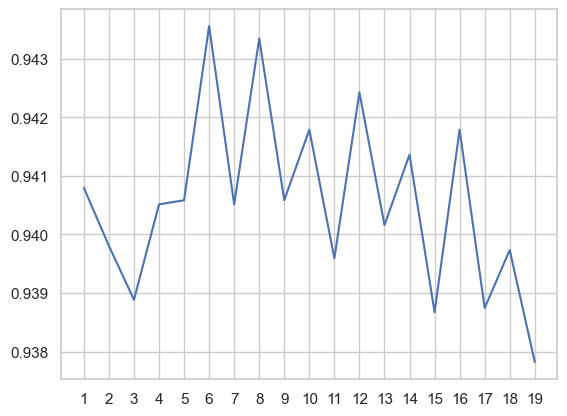

In [46]:
# Encontrando o melhor valor para K

result = []

for k in range(1, 20):
    # criando um objeto KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # treinando o modelo
    knn_classifier.fit(x_train, y_train_smote)
    
    # realizando predição
    yhat_knn = knn_classifier.predict(x_test)
    
    result.append(mt.accuracy_score(y_test, yhat_knn))

# Configurando o estilo do seaborn
sns.set(style="whitegrid")

ax = sns.lineplot(x=range(1, 20), y=result);
ax.set_xticks(np.arange(1, 20, 1));

In [47]:
# Verificando performance do modelo com K = 8

# criando um objeto KNN com k = 8
knn_classifier = KNeighborsClassifier(n_neighbors=8)

# treinando o modelo
knn_classifier.fit(x_train, y_train_smote)

# realizando predição
yhat_knn = knn_classifier.predict(x_test)

# acurácia
mt.accuracy_score(yhat_knn, y_test)

0.9433467884710715

## 7.2. Random Forest Classifier

In [48]:
# criando objeto Random Forest
rf = RandomForestClassifier(n_estimators=500,
                           n_jobs=-1,
                           random_state=42)

# treinamento
rf.fit(x_train, y_train_smote)

# previsão
yhat_rf = rf.predict(x_test)

# acurácia
mt.accuracy_score(yhat_rf, y_test)

0.9687699171446782

## 7.3. XGBoost Classifier

In [49]:
# criando objeto XGBClassifier
xgb_classifier = XGBClassifier(objective='reg:squarederror',
                                 n_estimators=500,
                                 eta=0.01,
                                 max_depth=10,
                                 subsample=0.7,
                                 colsample_bytree=0.9)

# treinamento
xgb_classifier.fit(x_train, y_train_smote)

# previsão
yhat_xgbc = xgb_classifier.predict(x_test)

# acurácia
mt.accuracy_score(yhat_xgbc, y_test)

0.9730189080093478

# 8.0. APLICANDO MODELO SELECIONADO

In [50]:
xtrain = X[cols_selected_boruta]

In [51]:
# criando objeto XGBClassifier
xgb_classifier = XGBClassifier(objective='reg:squarederror',
                                 n_estimators=1500,
                                 eta=0.01,
                                 max_depth=10,
                                 subsample=0.7,
                                 colsample_bytree=0.9)

# treinamento
xgb_classifier.fit(xtrain, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, objective='reg:squarederror', ...)

In [52]:
xtest = df_test[cols_selected_boruta]

yhat = xgb_classifier.predict(xtest)

df_final = pd.DataFrame(xtest['id'])
df_final['Reserva Cancelada'] = yhat

In [53]:
df_final.to_csv('csv_resposta/prediction.csv', index=False)

In [54]:
pickle.dump(xgb_classifier, open('model/xgb_classifier.pkl', 'wb'))

# 9.0. RESULTADO

![Leaderboard](img/leaderboard.JPG)

# 10.0. IMPLENTANDO EM PRODUÇÃO

## 10.1. COSTA DEL DATA

In [55]:
import pandas as pd
import pickle

# limpeza, transformações e encodes
class CostaDelData(object):
    def __init__(self):
        self.moda                               = pickle.load(open('parameter/moda.pkl', 'rb'))
        self.rs_meses_da_reserva_ate_o_check_in = pickle.load(open('parameter/rs_meses_da_reserva_ate_o_check_in.pkl', 'rb'))
        self.rs_numero_de_pernoites_reservadas  = pickle.load(open('parameter/rs_numero_de_pernoites_reservadas.pkl', 'rb'))
        self.rs_numero_de_hospedes              = pickle.load(open('parameter/rs_numero_de_hospedes.pkl', 'rb'))
        self.nacio_dict                         = pickle.load(open('parameter/nacio_dict.pkl', 'rb'))
        self.le_forma_de_reserva                = pickle.load(open('parameter/le_forma_de_reserva.pkl', 'rb'))
        self.le_tipo_do_quarto_reservado        = pickle.load(open('parameter/le_tipo_do_quarto_reservado.pkl', 'rb'))

    
    def data_cleaning(self, df1):      
        ## 1.1. Verificando as Colunas

        cols_old = ['id', 'Classificacao do hotel', 'Meses da reserva ate o check-in',
                    'Numero de pernoites reservadas', 'Numero de hospedes',
                    'Regime de alimentacao', 'Nacionalidade', 'Forma de Reserva',
                    'Ja se hospedou anteriormente', 'Tipo do quarto reservado',
                    'Reserva feita por agencia de turismo', 'Reserva feita por empresa',
                    'Reserva com Estacionamento', 'Reserva com Observacoes',
                    'Reserva Cancelada']

        snakecase = lambda x: x.replace(' ', '_').lower()

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        ## 1.5. Preenchendo os NA

        # numero_de_hospedes - substituiremos pela moda
        df1.loc[df1['numero_de_hospedes'].isna(), 'numero_de_hospedes'] = self.moda
    
        ## 1.6. Alterando os tipos dos dados

        df1.loc[:, 'numero_de_hospedes'] = df1['numero_de_hospedes'].astype('int64')
           
        return df1
    
    def data_preparation(self, df5):
        # 5.0. PREPARAÇÃO DOS DADOS

        ## 5.2.Redimensionamento

        # meses_da_reserva_ate_o_check-in
        df5['meses_da_reserva_ate_o_check-in'] = self.rs_meses_da_reserva_ate_o_check_in.transform(df5[['meses_da_reserva_ate_o_check-in']].values)

        # numero_de_pernoites_reservadas
        df5['numero_de_pernoites_reservadas'] = self.rs_numero_de_pernoites_reservadas.transform(df5[['numero_de_pernoites_reservadas']].values)

        # numero_de_hospedes
        df5['numero_de_hospedes'] = self.rs_numero_de_hospedes.transform(df5[['numero_de_hospedes']].values)

        ## 5.3. Encoding

        # classificacao_do_hotel - Ordinal Encoding
        class_hotel_dict = {'4 estrelas': 1, '5 estrelas': 2}
        df5['classificacao_do_hotel'] = df5['classificacao_do_hotel'].map(class_hotel_dict)

        # regime_de_alimentacao - Ordinal Encoding
        reg_alim_dict = {'Sem refeicao': 0, 
                         'Café da manha': 1,
                         'Café da manha e jantar': 2, 
                         'Café da manha, almoco e jantar': 3}
        df5['regime_de_alimentacao'] = df5['regime_de_alimentacao'].map(reg_alim_dict)

        # nacionalidade - Target Encoding
        df5['nacionalidade'] = df5['nacionalidade'].map(self.nacio_dict)

        # forma_de_reserva - Label Encoding
        df5['forma_de_reserva'] = self.le_forma_de_reserva.transform(df5['forma_de_reserva'])

        # tipo_do_quarto_reservado - Label Encoding
        df5['tipo_do_quarto_reservado'] = self.le_tipo_do_quarto_reservado.transform(df5['tipo_do_quarto_reservado'])

        # reserva_com_observacoes - Ordinal Encoding
        res_obs_dict = {'Nenhuma': 0,
                        '1 a 3': 1, 
                        'Mais de 3': 2}
        df5['reserva_com_observacoes'] = df5['reserva_com_observacoes'].map(res_obs_dict)

        # dicionário comum
        dict_yes_no = {'Sim': 1, 'Não': 0}

        # ja_se_hospedou_anteriormente - Ordinal Encoding
        df5['ja_se_hospedou_anteriormente'] = df5['ja_se_hospedou_anteriormente'].map(dict_yes_no)

        # reserva_feita_por_agencia_de_turismo - Ordinal Encoding
        df5['reserva_feita_por_agencia_de_turismo'] = df5['reserva_feita_por_agencia_de_turismo'].map(dict_yes_no)

        # reserva_feita_por_empresa - Ordinal Encoding
        df5['reserva_feita_por_empresa'] = df5['reserva_feita_por_empresa'].map(dict_yes_no)

        # reserva_com_estacionamento - Ordinal Encoding
        df5['reserva_com_estacionamento'] = df5['reserva_com_estacionamento'].map(dict_yes_no)
        
        # selecionando colunas
        cols_selected = ['id', 'classificacao_do_hotel', 'meses_da_reserva_ate_o_check-in', 
                         'numero_de_pernoites_reservadas', 'nacionalidade', 'reserva_com_estacionamento', 
                         'reserva_com_observacoes']
        
        df5 = df5.fillna(0)        
        
        return df5[cols_selected]
        
    def get_prediction(self,  model, original_data, test_data):
        # preditor
        pred = model.predict( test_data )
                
        original_data['predictions'] = pred
        
        return original_data.to_json(orient='records')

## 10.2. API HANDLER

In [56]:
import pandas as pd
import pickle

from flask                     import Flask, request, Response
from costadeldata.CostaDelData import CostaDelData

model = pickle.load(open('model/xgb_classifier.pkl', 'rb'))

app = Flask[__name__]

@app.route('/costadeldata/predict', methods=['POST'])
def costadeldata_predict():
    test_json = request.get_json()
    
    if test_json: # test_json tem dados
        if isinstance(test_json, dict): # exemplo único
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instanciando a Classe CostaDelData
        pipeline = CostaDelData()
        
        # limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # preparação dos dados
        df2 = pipeline.data_preparation(df1)
        
        # predição
        df_response = pipeline.get_prediction(model = model, original_data = test_raw, test_data = df2)
        
        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'flask'

## 10.3. API PARA TESTE

In [58]:
df10 = pd.read_csv('csv/test.csv')

In [59]:
import json

# dados para predição
df_test = df10.sample(50)

# dataframe para json
data = json.dumps(df_test.to_dict(orient='records'))

In [67]:
import requests

# API
url = 'https://hack-day-4.onrender.com/costadeldata/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [68]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [69]:
d1

,id,classificacao_do_hotel,meses_da_reserva_ate_o_check-in,numero_de_pernoites_reservadas,numero_de_hospedes,regime_de_alimentacao,nacionalidade,forma_de_reserva,ja_se_hospedou_anteriormente,tipo_do_quarto_reservado,reserva_feita_por_agencia_de_turismo,reserva_feita_por_empresa,reserva_com_estacionamento,reserva_com_observacoes,predictions
0,25968,2,-0.4,-0.5,-1.0,1,0.474663,1,1,0,0,1,0,1,0
1,21659,2,-0.4,5.5,0.0,1,0.757164,0,0,0,1,0,0,0,0
2,103348,1,-0.2,0.5,1.0,1,0.740741,0,0,0,1,0,0,1,0
3,110837,1,1.0,1.0,0.0,1,0.814934,2,0,1,1,0,0,0,0
4,106426,1,30.4,42.0,0.0,1,0.814934,0,0,0,1,0,0,0,0
5,49378,1,0.2,-1.0,0.0,1,0.474663,0,0,0,1,0,0,0,1
6,48840,1,0.0,0.0,0.0,0,0.814757,0,0,0,1,0,0,1,0
7,98977,1,-0.4,-1.0,0.0,0,0.757749,0,0,0,1,0,0,0,0
8,36922,2,2.0,0.0,0.0,1,NaN,0,0,5,1,0,0,1,0
9,77074,1,0.8,-0.5,0.0,1,0.474663,0,0,0,1,0,0,0,1
